In [1]:
%%capture output
!pip install --upgrade pip
!pip install --upgrade pandas
!pip install tables   
# necessary for pd.read_hdf()

!pip install ipywidgets
!pip install --upgrade jupyter
!pip install IProgress
!pip install catboost
!pip install shap
!pip install anndata

In [2]:
import os
import random
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, GroupKFold
import scipy
import anndata as ad
import shap

/dss/dsshome1/02/di93zoj/.local/lib/python3.8/site-packages/cupy/_environment.py:445: UserWarning: 
--------------------------------------------------------------------------------

  CuPy may not function correctly because multiple CuPy packages are installed
  in your environment:

    cupy-cuda11x, cupy-cuda12x

  Follow these steps to resolve this issue:

    1. For all packages listed above, run the following command to remove all
       existing CuPy installations:

         $ pip uninstall <package_name>

      If you previously installed CuPy via conda, also run the following:

         $ conda uninstall cupy

    2. Install the appropriate CuPy package.
       Refer to the Installation Guide for detailed instructions.

         https://docs.cupy.dev/en/stable/install.html

--------------------------------------------------------------------------------

  warnings.warn(f'''


In [3]:
%matplotlib inline
from tqdm.notebook import tqdm
import gc
import pickle

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda")
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

## data load

In [4]:
lrz_path = '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93zoj/open-problems-multimodal-3rd-solution/'

model_path_for_now = '/dss/dsshome1/02/di93zoj/valentina/open-problems-multimodal-3rd-solution/'

raw_path =  lrz_path + 'input/raw/'  # '../../../input/raw/'

cite_target_path = lrz_path + 'input/target/cite/'   # '../../../input/target/cite/'
cite_feature_path = lrz_path + 'input/features/cite/'   # '../../../input/features/cite/'
cite_mlp_path = lrz_path + 'model/cite/mlp/'   # '../../../model/cite/mlp/'   # '../../../model/cite/mlp/'
cite_cb_path = lrz_path + 'model/cite/cb/'   # '../../../model/cite/cb/'

multi_target_path = lrz_path + 'input/target/multi/'   # '../../../input/target/multi/'
multi_feature_path = lrz_path + 'input/features/multi/'   # '../../../input/features/multi/'
multi_mlp_path = lrz_path + 'model/multi/mlp/'   # '../../../model/multi/mlp/'
multi_cb_path = lrz_path + 'model/multi/cb/'   # '../../../model/multi/cb/'

index_path = lrz_path + 'input/preprocess/cite/'

output_path = lrz_path + 'output/'   # '../../../output/'

## Cite

In [5]:
# get model name
#mlp_model_path = os.listdir(cite_mlp_path)

In [6]:
mlp_model_name = [
    'corr_add_con_imp',
    'corr_last_v3', 
    'corr_c_add_w2v_v1_mish_flg',
    'corr_c_add_w2v_v1_flg',
    'corr_c_add_84_v1',
    'corr_c_add_120_v1',
    'corr_w2v_cell_flg',
    'corr_best_cell_120',
    'corr_cluster_cell',
    'corr_w2v_128',
    'corr_imp_w2v_128',
    'corr_snorm',
    'corr_best_128',
    'corr_best_64',
    'corr_cluster_128',
    'corr_cluster_64',
    'corr_svd_128',
    'corr_svd_64',
             ]

In [7]:
model_name_list = []

for i in mlp_model_name:
    for num, j in enumerate(os.listdir(cite_mlp_path)):
        if i in j:
            model_name_list.append(j)

len(model_name_list)
model_name_list

['cite_mlp_corr_add_con_imp_flg_donor_val_50',
 'cite_mlp_corr_last_v3_flg_donor_val_55',
 'cite_mlp_corr_c_add_w2v_v1_mish_flg_donor_val_66',
 'cite_mlp_corr_c_add_w2v_v1_flg_donor_val_66',
 'cite_mlp_corr_c_add_84_v1_flg_donor_val_47',
 'cite_mlp_corr_c_add_120_v1_flg_donor_val_63',
 'cite_mlp_corr_w2v_cell_flg_donor_val_51',
 'cite_mlp_corr_best_cell_120_flg_donor_val_51',
 'cite_mlp_corr_cluster_cell_flg_donor_val_64',
 'cite_mlp_corr_w2v_128_flg_donor_val_42',
 'cite_mlp_corr_imp_w2v_128_flg_donor_val_38',
 'cite_mlp_corr_snorm_flg_donor_val_39',
 'cite_mlp_corr_best_128_flg_donor_val_45',
 'cite_mlp_corr_best_64_flg_donor_val_50',
 'cite_mlp_corr_cluster_128_flg_donor_val_51',
 'cite_mlp_corr_cluster_64_flg_donor_val_57',
 'cite_mlp_corr_svd_128_flg_donor_val_30',
 'cite_mlp_corr_svd_64_flg_donor_val_38']

In [8]:
weight = [1, 0.3, 1, 1, 1, 1, 1, 1, 1, 0.8, 0.8, 0.8, 0.8, 0.5, 0.5, 0.5, 1, 1, 2, 2]
weight_sum = np.array(weight).sum()
weight_sum

model_feat_dict = {model_name_list[0]:['X_test_add_con_imp.pickle', 1],
                   model_name_list[1]:['X_test_last_v3.pickle', 0.3],
                   model_name_list[2]:['X_test_c_add_w2v_v1.pickle', 1],
                   model_name_list[3]:['X_test_c_add_w2v_v1.pickle', 1],
                   model_name_list[4]:['X_test_c_add_84_v1.pickle', 1],
                   model_name_list[5]:['X_test_c_add_v1.pickle', 1],
                   
                   model_name_list[6]:['X_test_feature_w2v_cell.pickle', 1],
                   model_name_list[7]:['X_test_best_cell_128_120.pickle', 1],
                   model_name_list[8]:['X_test_cluster_cell_128.pickle', 1],
                   
                   model_name_list[9]:['X_test_feature_w2v.pickle', 0.8],
                   model_name_list[10]:['X_test_feature_imp_w2v.pickle',0.8],
                   model_name_list[11]:['X_test_feature_snorm.pickle', 0.8],
                   model_name_list[12]:['X_test_best_128.pickle', 0.8],
                   model_name_list[13]:['X_test_best_64.pickle', 0.5],
                   model_name_list[14]:['X_test_cluster_128.pickle', 0.5],
                   model_name_list[15]:['X_test_cluster_64.pickle', 0.5],
                   model_name_list[16]:['X_test_svd_128.pickle', 1],
                   model_name_list[17]:['X_test_svd_64.pickle', 1],
                   
                   'best_128':['X_test_best_128.pickle', 2],
                   'best_64':['X_test_best_64.pickle', 2],
                  }

### cite model

In [9]:
def std(x):
    x = np.array(x)
    return (x - x.mean(1).reshape(-1, 1)) / x.std(1).reshape(-1, 1)

In [10]:
class CiteDataset(Dataset):
    
    def __init__(self, feature, target):
        
        self.feature = feature
        self.target = target
        
    def __len__(self):
        return len(self.feature)
    
    def __getitem__(self, index):
                
        d = {
            "X": self.feature[index],
            "y" : self.target[index],
        }
        return d

In [11]:
class CiteDataset_test(Dataset):
    
    def __init__(self, feature):
        self.feature = feature
        
    def __len__(self):
        return len(self.feature)
    
    def __getitem__(self, index):
                
        d = {
            "X": self.feature[index]
        }
        return d

In [12]:
def partial_correlation_score_torch_faster(y_true, y_pred):
    """Compute the correlation between each rows of the y_true and y_pred tensors.
    Compatible with backpropagation.
    """
    y_true_centered = y_true - torch.mean(y_true, dim=1)[:,None]
    y_pred_centered = y_pred - torch.mean(y_pred, dim=1)[:,None]
    cov_tp = torch.sum(y_true_centered*y_pred_centered, dim=1)/(y_true.shape[1]-1)
    var_t = torch.sum(y_true_centered**2, dim=1)/(y_true.shape[1]-1)
    var_p = torch.sum(y_pred_centered**2, dim=1)/(y_true.shape[1]-1)
    return cov_tp/torch.sqrt(var_t*var_p)

def correl_loss(pred, tgt):
    """Loss for directly optimizing the correlation.
    """
    return -torch.mean(partial_correlation_score_torch_faster(tgt, pred))

In [13]:
class CiteModel(nn.Module):
    
    def __init__(self, feature_num):
        super(CiteModel, self).__init__()
        
        self.layer_seq_256 = nn.Sequential(nn.Linear(feature_num, 256),
                                           nn.Linear(256, 128),
                                       nn.LayerNorm(128),
                                       nn.ReLU(),
                                      )
        self.layer_seq_64 = nn.Sequential(nn.Linear(128, 64),
                                       nn.Linear(64, 32),
                                       nn.LayerNorm(32),
                                       nn.ReLU(),
                                      )
        self.layer_seq_8 = nn.Sequential(nn.Linear(32, 16),
                                         nn.Linear(16, 8),
                                       nn.LayerNorm(8),
                                       nn.ReLU(),
                                      )
        
        self.head = nn.Linear(128 + 32 + 8, 140)
                   
    def forward(self, X, y=None):
        
        from_numpy = False
        
      ##
        if isinstance(X, np.ndarray):
            X = torch.from_numpy(X)
            from_numpy = True
        X = X.to(device)  # Move the input to the appropriate device if necessary
        ##
        X_256 = self.layer_seq_256(X)
        X_64 = self.layer_seq_64(X_256)
        X_8 = self.layer_seq_8(X_64)
        
        X = torch.cat([X_256, X_64, X_8], axis = 1)
        out = self.head(X)
        
        if from_numpy:
            out = out.cpu().detach().numpy()
            
        return out

In [14]:
class CiteModel_mish(nn.Module):
    
    def __init__(self, feature_num):
        super(CiteModel_mish, self).__init__()
        
        self.layer_seq_256 = nn.Sequential(nn.Linear(feature_num, 256),
                                           nn.Linear(256, 128),
                                       nn.LayerNorm(128),
                                       nn.Mish(),
                                      )
        self.layer_seq_64 = nn.Sequential(nn.Linear(128, 64),
                                       nn.Linear(64, 32),
                                       nn.LayerNorm(32),
                                       nn.Mish(),
                                      )
        self.layer_seq_8 = nn.Sequential(nn.Linear(32, 16),
                                         nn.Linear(16, 8),
                                       nn.LayerNorm(8),
                                       nn.Mish(),
                                      )
        
        self.head = nn.Linear(128 + 32 + 8, 140)
                   
    def forward(self, X, y=None):
    
        X_256 = self.layer_seq_256(X)
        X_64 = self.layer_seq_64(X_256)
        X_8 = self.layer_seq_8(X_64)
        
        X = torch.cat([X_256, X_64, X_8], axis = 1)
        out = self.head(X)
        
        return out

In [15]:
def train_loop(model, optimizer, loader, epoch):
    
    losses, lrs = [], []
    model.train()
    optimizer.zero_grad()
    #loss_fn = nn.MSELoss()
    
    with tqdm(total=len(loader),unit="batch") as pbar:
        pbar.set_description(f"Epoch{epoch}")
        
        for d in loader:
            X = d['X'].to(device)
            y = d['y'].to(device)
            
            logits = model(X)
            loss = correl_loss(logits, y)
            #loss = torch.sqrt(loss_fn(logits, y))
        
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            pbar.set_postfix({"loss":loss.item()})
            pbar.update(1)

    return model

In [16]:
def valid_loop(model, loader, y_val):
    
    model.eval()
    partial_correlation_scores = []
    oof_pred = []
    
    for d in loader:
        with torch.no_grad():
            val_X = d['X'].to(device).float()
            val_y = d['y'].to(device)
            logits = model(val_X)
            oof_pred.append(logits)
    
    #print(torch.cat(oof_pred).shape, torch.cat(oof_pred).detach().cpu().numpy().shape)
    cor = partial_correlation_score_torch_faster(torch.tensor(y_val).to(device), torch.cat(oof_pred))
    cor = cor.mean().item()
    logits = torch.cat(oof_pred).detach().cpu().numpy()
    
    return logits, cor

In [17]:
def test_loop(model, loader):
    
    model.eval()
    predicts=[]

    for d in tqdm(loader):
        with torch.no_grad():
            X = d['X'].to(device)
            logits = model(X)
            predicts.append(logits.detach().cpu().numpy())
            
    return np.concatenate(predicts)

### pred

In [18]:
pred = np.zeros([48203, 140])

for num, i in enumerate(model_feat_dict.keys()):
    
    print(i)
    
    if 'mlp' in i:

        try:
            test_file = model_feat_dict[i][0]
            test_weight = model_feat_dict[i][1]
            X_test = pd.read_pickle(cite_feature_path  + test_file)   
            # print(cite_feature_path  + test_file)
            X_test = np.array(X_test)
            feature_dims = X_test.shape[1]

            test_ds = CiteDataset_test(X_test)
            test_dataloader = DataLoader(test_ds, batch_size=128, pin_memory=True, 
                                         shuffle=False, drop_last=False, num_workers=4)

            if 'mish' in i:
                model = CiteModel_mish(feature_dims)
            else:
                model = CiteModel(feature_dims)

            model = model.to(device)
            model.load_state_dict(torch.load(f'{cite_mlp_path}/{i}'))

            result = test_loop(model, test_dataloader).astype(np.float32)
            result = std(result) * test_weight / weight_sum
            pred += result

            torch.cuda.empty_cache()

        except Exception as e: 
            print(i)
            print(e)             # TODOOOOOOOOOOOOOO
        
    else:
        test_file = model_feat_dict[i][0]
        test_weight = model_feat_dict[i][1]
        X_test = pd.read_pickle(cite_feature_path  + test_file)
        
        cb_pred = np.zeros([48203, 140])
        
        for t in tqdm(range(140)): 
            cb_model_path = [j for j in os.listdir(cite_cb_path) if f'cb_{t}_{i}' in j][0]
            cb = pickle.load(open(cite_cb_path + cb_model_path, 'rb'))
            cb_pred[:,t] = cb.predict(X_test)
            
        cb_pred = cb_pred.astype(np.float32)
        pred += std(cb_pred) * test_weight / weight_sum
        
        del cb_pred

cite_mlp_corr_add_con_imp_flg_donor_val_50


  0%|          | 0/377 [00:00<?, ?it/s]

cite_mlp_corr_last_v3_flg_donor_val_55


  0%|          | 0/377 [00:00<?, ?it/s]

cite_mlp_corr_c_add_w2v_v1_mish_flg_donor_val_66


  0%|          | 0/377 [00:00<?, ?it/s]

cite_mlp_corr_c_add_w2v_v1_flg_donor_val_66


  0%|          | 0/377 [00:00<?, ?it/s]

cite_mlp_corr_c_add_84_v1_flg_donor_val_47


  0%|          | 0/377 [00:00<?, ?it/s]

cite_mlp_corr_c_add_120_v1_flg_donor_val_63


  0%|          | 0/377 [00:00<?, ?it/s]

cite_mlp_corr_w2v_cell_flg_donor_val_51


  0%|          | 0/377 [00:00<?, ?it/s]

cite_mlp_corr_best_cell_120_flg_donor_val_51


  0%|          | 0/377 [00:00<?, ?it/s]

cite_mlp_corr_cluster_cell_flg_donor_val_64


  0%|          | 0/377 [00:00<?, ?it/s]

cite_mlp_corr_w2v_128_flg_donor_val_42
cite_mlp_corr_w2v_128_flg_donor_val_42
pickle data was truncated
cite_mlp_corr_imp_w2v_128_flg_donor_val_38


  0%|          | 0/377 [00:00<?, ?it/s]

cite_mlp_corr_snorm_flg_donor_val_39


  0%|          | 0/377 [00:00<?, ?it/s]

cite_mlp_corr_best_128_flg_donor_val_45


  0%|          | 0/377 [00:00<?, ?it/s]

cite_mlp_corr_best_64_flg_donor_val_50


  0%|          | 0/377 [00:00<?, ?it/s]

cite_mlp_corr_cluster_128_flg_donor_val_51
cite_mlp_corr_cluster_128_flg_donor_val_51
pickle data was truncated
cite_mlp_corr_cluster_64_flg_donor_val_57


  0%|          | 0/377 [00:00<?, ?it/s]

cite_mlp_corr_svd_128_flg_donor_val_30


  0%|          | 0/377 [00:00<?, ?it/s]

cite_mlp_corr_svd_64_flg_donor_val_38


  0%|          | 0/377 [00:00<?, ?it/s]

best_128


  0%|          | 0/140 [00:00<?, ?it/s]

TBB Warning: The number of workers is currently limited to 9. The request for 79 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.



best_64


  0%|          | 0/140 [00:00<?, ?it/s]

In [19]:
cite_sub = pd.DataFrame(pred.round(6))
cite_sub

0         1         2         3         4         5         6    \
0     -0.325767 -0.487738 -0.351139  1.035394  0.867302  2.263471  3.314403   
1     -0.293307 -0.470185 -0.351417  1.042340  0.918223  2.295353  3.557569   
2     -0.337575 -0.449081 -0.328770  1.541549  1.271137  1.486816  4.438023   
3     -0.545628 -0.456024 -0.227837  1.033564  1.055734  0.821383 -0.552602   
4     -0.431234 -0.457296 -0.305963  1.119193  1.234073  1.999678  0.747365   
...         ...       ...       ...       ...       ...       ...       ...   
48198 -0.054573 -0.461926 -0.341083  1.134846  1.049176  2.120080  3.180188   
48199 -0.185888 -0.444854 -0.343561  0.672553  0.861765  2.108776  1.989787   
48200 -0.403580 -0.082392 -0.178023  0.457895  0.854246  1.258473 -0.298337   
48201 -0.611163 -0.492633 -0.254988  0.836261  0.370830  1.080112 -0.544935   
48202 -0.582459 -0.439802 -0.232348  0.938192  0.096082  1.465832 -0.511263   

            7         8         9         10        11        12        13   \
0     -0.490992 -0.422089 -0.312560 -0.516754 -0.479289 -0.392685 -0.437807   
1     -0.485068 -0.415240 -0.313825 -0.507285 -0.467309 -0.390135 -0.437772   
2     -0.463581 -0.391279 -0.423727 -0.490480 -0.432064 -0.413590 -0.419570   
3     -0.326394 -0.313855 -0.501781 -0.593891 -0.443928 -0.474153 -0.423425   
4     -0.422706 -0.372396 -0.273251 -0.523010 -0.495150 -0.444115 -0.200126   
...         ...       ...       ...       ...       ...       ...       ...   
48198 -0.506037 -0.407075 -0.361818 -0.524070 -0.490738 -0.425430 -0.458783   
48199 -0.510823 -0.425530 -0.225415 -0.525032 -0.498547 -0.385120 -0.458317   
48200  0.233589 -0.291241 -0.310360 -0.391955 -0.364783 -0.354641 -0.319110   
48201 -0.391174 -0.249658 -0.564887 -0.651619 -0.444062 -0.499969 -0.373597   
48202 -0.442574 -0.202834 -0.563408 -0.667667 -0.407583 -0.468935 -0.343172   

            14        15        16        17        18        19        20   \
0      2.248444 -0.356812  1.858463  1.438221  0.311931 -0.459447 -0.390223   
1      2.081140 -0.379274  1.817812  1.527190  0.218958 -0.443928 -0.396843   
2      3.426018 -0.273052  1.050578  1.232067 -0.147889 -0.459557 -0.391296   
3      2.130011 -0.528410  0.988624 -0.494499 -0.096683  0.038583 -0.389364   
4      1.387469 -0.319276  1.590317  0.254497  0.447762 -0.503618 -0.358644   
...         ...       ...       ...       ...       ...       ...       ...   
48198  2.527242 -0.378397  1.956162  1.406370  0.183506 -0.467012 -0.410843   
48199  1.954383 -0.316542  1.748607  1.750318  0.494778 -0.501639 -0.426965   
48200  0.006287 -0.320871  1.117434 -0.333953 -0.283152 -0.362012 -0.309936   
48201  1.323249 -0.606499  0.677841 -0.406055 -0.469449 -0.353353 -0.332590   
48202  1.135352 -0.619481  0.369045 -0.511901 -0.376160 -0.462370  0.025407   

            21        22        23        24        25        26        27   \
0      0.357044 -0.487529 -0.386469  2.933681 -0.493526 -0.496832 -0.490686   
1      0.337870 -0.473521 -0.378367  2.997932 -0.475288 -0.487909 -0.482030   
2      0.349071 -0.452589 -0.377862  2.946249 -0.457357 -0.465505 -0.456003   
3      0.661114 -0.493974 -0.367607  1.727922 -0.516392 -0.557609 -0.603955   
4      0.426424 -0.521209 -0.464568  3.825411 -0.486512 -0.528470 -0.462716   
...         ...       ...       ...       ...       ...       ...       ...   
48198  0.342722 -0.500307 -0.278809  3.113495 -0.502710 -0.520716 -0.477593   
48199  0.354644 -0.501101 -0.218480  2.868546 -0.496575 -0.525409 -0.459926   
48200  1.824702 -0.313959 -0.257192 -0.030984 -0.342284 -0.354349 -0.370419   
48201  1.138953 -0.611951 -0.388739  1.600320 -0.525084 -0.617054 -0.665517   
48202  1.175980 -0.606301 -0.402351  1.954561 -0.515187 -0.606837 -0.668043   

            28        29        30        31        32        33        34   \
0     -0.519472 -0.486443 -0.499483 -0.456832 -0.462952 -0.465901 -0.445472   
1     -0.519096 -0.478371 -0.486569 -0.440771 -0.453228 -0

In [20]:
#cite_sub.to_csv('../../../../../summary/output/submit/cite_submit.csv')

In [21]:
# model #16: cite_mlp_corr_svd_128_flg_donor_val_30
pred_16 = np.zeros([48203, 140])

i = 'cite_mlp_corr_svd_128_flg_donor_val_30'
        
test_file = model_feat_dict[i][0]
test_weight = model_feat_dict[i][1]
X_test = pd.read_pickle(cite_feature_path  + test_file)
X_test = np.array(X_test)
feature_dims = X_test.shape[1]

test_ds = CiteDataset_test(X_test)
test_dataloader = DataLoader(test_ds, batch_size=128, pin_memory=True, 
                              shuffle=False, drop_last=False, num_workers=4)

if 'mish' in i:
    model = CiteModel_mish(feature_dims)
else:
    model = CiteModel(feature_dims)
    
model = model.to(device)
model.load_state_dict(torch.load(f'{cite_mlp_path}/{i}'))

result = test_loop(model, test_dataloader).astype(np.float32)
pred_16 += result

torch.cuda.empty_cache()
        
pd.DataFrame(pred_16)   # double check train_cite_targets.h5  -> omnipath

  0%|          | 0/377 [00:00<?, ?it/s]

0         1         2         3         4         5         6    \
0     -1.066433 -1.500550 -1.354774  1.106190  0.869803  3.481040  5.067837   
1     -1.067110 -1.506955 -1.399289  1.075526  0.997081  3.506622  5.481764   
2     -1.010656 -1.271471 -1.207577  2.074188  1.614956  2.007590  6.589465   
3     -1.506548 -1.336604 -1.056332  0.852848  0.946436  0.652196 -1.553841   
4     -1.272211 -1.349656 -1.142900  1.304754  1.531233  2.833454  0.443823   
...         ...       ...       ...       ...       ...       ...       ...   
48198 -0.520571 -1.446298 -1.333212  1.226779  1.118786  2.732154  4.920837   
48199 -0.641409 -1.391113 -1.307034  0.296210  0.626469  2.656102  2.535754   
48200 -1.383966 -0.817277 -1.052890  0.099039  0.724624  1.477175 -1.276211   
48201 -1.510795 -1.396045 -0.933571  0.539321 -0.054786  1.035743 -1.380013   
48202 -1.257885 -1.123296 -0.799638  0.694056 -0.483587  1.462265 -1.332646   

            7         8         9         10        11        12        13   \
0     -1.570396 -1.444474 -1.320852 -1.612052 -1.534098 -1.428519 -1.496802   
1     -1.564466 -1.460833 -1.301538 -1.630497 -1.572419 -1.490347 -1.531179   
2     -1.374983 -1.260541 -1.450437 -1.464440 -1.332187 -1.378543 -1.357404   
3     -1.178436 -1.245057 -1.485463 -1.608860 -1.321451 -1.367749 -1.370948   
4     -1.292403 -1.201001 -1.091781 -1.517518 -1.415199 -1.428606 -0.868173   
...         ...       ...       ...       ...       ...       ...       ...   
48198 -1.530176 -1.416398 -1.343555 -1.581935 -1.536683 -1.521394 -1.430096   
48199 -1.514254 -1.408760 -1.089353 -1.525036 -1.494595 -1.320098 -1.396001   
48200 -0.455357 -1.187938 -1.269387 -1.238588 -1.340240 -1.310978 -1.315726   
48201 -1.157287 -1.002030 -1.549959 -1.639010 -1.197559 -1.376003 -1.238775   
48202 -1.137664 -0.821833 -1.349147 -1.480256 -0.985875 -1.213061 -1.012871   

            14        15        16        17        18        19        20   \
0      3.095008 -1.384286  2.648872  1.938160 -0.093022 -1.635664 -1.428120   
1      3.168335 -1.427267  2.470253  2.130677 -0.441134 -1.637434 -1.472109   
2      4.944262 -1.135714  0.924946  1.518677 -0.864071 -1.520523 -1.308277   
3      2.458670 -1.584513  0.834877 -1.507935 -0.873383 -0.723710 -1.385123   
4      1.900248 -1.324359  2.231340 -0.143202  0.213205 -1.557858 -1.172046   
...         ...       ...       ...       ...       ...       ...       ...   
48198  3.644986 -1.375152  2.543882  1.617501 -0.595053 -1.600122 -1.383155   
48199  2.516135 -1.145856  1.904267  2.167556  0.087699 -1.627212 -1.416891   
48200 -0.761487 -1.423979  1.071221 -1.156683 -1.209055 -1.126398 -1.265997   
48201  1.158366 -1.503967  0.408375 -1.166183 -1.076883 -1.127724 -1.130991   
48202  0.644134 -1.402113 -0.107881 -1.284641 -1.010846 -1.164434 -0.493726   

            21        22        23        24        25        26        27   \
0     -0.072564 -1.464633 -1.333522  4.528148 -1.577123 -1.570215 -1.564498   
1     -0.058242 -1.472134 -1.346540  4.738451 -1.580705 -1.617835 -1.605957   
2      0.001427 -1.352170 -1.241024  4.492778 -1.413115 -1.387910 -1.474926   
3      0.240378 -1.443920 -1.212697  1.991319 -1.421182 -1.507708 -1.561859   
4      0.056330 -1.476984 -1.390703  6.038998 -1.469662 -1.585841 -1.370464   
...         ...       ...       ...       ...       ...       ...       ...   
48198 -0.133517 -1.428545 -1.162127  4.858096 -1.533847 -1.576231 -1.550021   
48199 -0.120703 -1.433683 -0.953134  4.334615 -1.470356 -1.526713 -1.423867   
48200  2.207539 -1.148840 -1.129911 -0.614602 -1.170780 -1.252894 -1.292672   
48201  1.260304 -1.625534 -1.113135  2.026301 -1.382103 -1.562430 -1.652046   
48202  1.182165 -1.433039 -1.037571  2.015571 -1.214636 -1.430479 -1.528496   

            28        29        30        31        32        33        34   \
0     -1.633450 -1.551511 -1.606082 -1.488960 -1.542044 -1.542291 -1.515924   
1     -1.660571 -1.576319 -1.645333 -1.515913 -1.583853 -1

### prediction with private test input -> should get private test target

In [22]:
private_test_input = ad.read('/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93zoj/large_preprocessed_files/private_test_input.h5ad')
private_test_input

AnnData object with n_obs × n_vars = 26867 × 22085
    obs: 'kaggle_dataset', 'day', 'donor', 'cell_type'

In [23]:
private_test_target = ad.read('/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93zoj/large_preprocessed_files/private_test_target.h5ad')
private_test_target

AnnData object with n_obs × n_vars = 26867 × 140
    obs: 'kaggle_dataset', 'day', 'donor', 'cell_type'

In [24]:
private_test_target_raw = ad.read('/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93zoj/large_preprocessed_files/private_test_target_raw.h5ad')
private_test_target_raw

AnnData object with n_obs × n_vars = 26867 × 140
    obs: 'kaggle_dataset', 'day', 'donor', 'cell_type'

In [117]:
with open('private_X_test_svd.pkl', 'rb') as f:  # private_X_test_svd

    private_X_test_svd = pickle.load(f)
private_X_test_svd.shape

(26867, 212)

In [118]:
with open('private_X_test_svd_from_raw.pkl', 'rb') as f:  # private_X_test_svd

    private_X_test_svd_from_raw = pickle.load(f)
private_X_test_svd_from_raw.shape

(26867, 212)

In [121]:
# model #16: cite_mlp_corr_svd_128_flg_donor_val_30
pred_16 = np.zeros([26867, 140])

i = 'cite_mlp_corr_svd_128_flg_donor_val_30'
        
# test_file = model_feat_dict[i][0]
# test_weight = model_feat_dict[i][1]
X_test = private_X_test_svd
X_test = np.array(X_test)
feature_dims = X_test.shape[1]

test_ds = CiteDataset_test(X_test)
test_dataloader = DataLoader(test_ds, batch_size=128, pin_memory=True, 
                              shuffle=False, drop_last=False, num_workers=4)

if 'mish' in i:
    model = CiteModel_mish(feature_dims)
else:
    model = CiteModel(feature_dims)
    
model = model.to(device)
model.load_state_dict(torch.load(f'{cite_mlp_path}/{i}'))

result = test_loop(model, test_dataloader).astype(np.float32)
pred_16 += result

torch.cuda.empty_cache()
        
pd.DataFrame(pred_16)

  0%|          | 0/210 [00:00<?, ?it/s]

0         1         2         3         4         5         6    \
0     -0.373409 -1.285452 -1.181257  0.866390  0.147068  1.610274  5.513695   
1     -0.972495 -1.184871 -1.100264  1.110875  1.479862  1.612517  2.388191   
2     -0.528387 -1.134755 -1.056973  0.950950 -0.029304  2.967266  2.363688   
3     -0.324637 -1.389314 -1.273155  0.844723  0.462561  1.727518  5.864649   
4     -1.042343 -1.467812 -1.262910  0.782575  0.860313  2.148421  4.348184   
...         ...       ...       ...       ...       ...       ...       ...   
26862 -0.738951 -1.295634 -1.202343  1.201276  1.333224  1.985777  4.528436   
26863 -0.704849 -1.339128 -1.258211  0.762863  1.196308  1.797357  4.514954   
26864 -1.343651 -0.834328 -1.121356  0.731786  1.173013  1.628691 -1.314416   
26865 -1.061061 -1.281089 -1.167807  0.768146  0.679042  1.600435  1.399648   
26866 -0.834208 -1.173771 -1.041101  0.903357  0.543149  1.360984  1.353746   

            7         8         9         10        11        12        13   \
0     -1.326972 -1.120104 -0.849544 -1.430125 -1.486018 -1.378166 -1.343360   
1     -1.161401 -1.084497 -0.937716 -1.308460 -1.320031 -1.274108 -1.216669   
2     -1.269510 -1.100845 -1.033805 -1.288254 -1.253856 -1.170123 -1.318315   
3     -1.410896 -1.246113 -0.983316 -1.545614 -1.593400 -1.479617 -1.458874   
4     -0.915376 -1.276812 -0.902049 -1.517980 -1.444453 -1.430214  0.098495   
...         ...       ...       ...       ...       ...       ...       ...   
26862 -1.277086 -1.160192 -1.185219 -1.409157 -1.414592 -1.359207 -1.355509   
26863 -1.339286 -1.234906 -1.108053 -1.476217 -1.491853 -1.369631 -1.359509   
26864 -0.667597 -1.286214 -1.300030 -1.342806 -1.393325 -1.367258 -1.391059   
26865 -0.958550 -1.193355 -1.163337 -1.488940 -1.309199 -1.373455 -0.717327   
26866 -1.092369 -0.982818 -1.308352 -1.390339 -1.139333 -1.239076 -1.212690   

            14        15        16        17        18        19        20   \
0      2.520270  0.189322  0.162977 -1.085166 -1.083710 -1.661598 -1.197479   
1      2.997455 -0.675659  0.505796 -0.076950  0.563774 -0.978574 -1.051314   
2      3.836658 -0.330308  1.445221 -1.224294 -1.018461 -1.343340 -1.223254   
3      2.121546 -0.239702  0.388544 -0.966809 -1.364197 -1.900109 -1.204695   
4      2.719480 -0.528870  0.143972  0.312106 -0.865757 -1.654015 -1.324172   
...         ...       ...       ...       ...       ...       ...       ...   
26862  3.534286 -0.985809  0.283740  0.553199  0.140648 -1.234677 -1.181080   
26863  2.908419 -0.920598  0.460226  0.880823  0.226361 -1.299989 -1.169599   
26864  0.538627 -1.618963  0.343534 -1.374236 -0.680923 -1.016804 -1.302659   
26865  2.106979 -1.372610 -0.433419 -0.616017 -0.550375 -1.179592 -1.148521   
26866  2.490831 -1.053205 -0.691203 -0.976659 -0.265684 -1.071865 -0.919317   

            21        22        23        24        25        26        27   \
0     -1.001668 -1.264128 -1.176874  2.679246 -1.254575 -1.424422 -1.443570   
1     -0.072966 -1.135781 -1.087284  3.529760 -1.250505 -1.296861 -1.313284   
2     -0.818053 -1.095535 -1.086939  0.828890 -1.222408 -1.320656 -1.290488   
3     -1.147593 -1.395681 -1.193522  2.482869 -1.444286 -1.503718 -1.521097   
4     -0.695571 -1.408280 -1.179196  3.197630 -1.265890 -1.496186 -1.375422   
...         ...       ...       ...       ...       ...       ...       ...   
26862 -0.256899 -1.221792 -1.159960  3.372722 -1.352122 -1.378718 -1.400422   
26863 -0.258330 -1.258402 -1.040460  3.082501 -1.431970 -1.477705 -1.500225   
26864  1.362963 -1.114963 -1.321365  0.590738 -1.248186 -1.335942 -1.349390   
26865 -0.171955 -1.362070 -1.047391  2.394623 -1.290097 -1.457857 -1.447448   
26866 -0.101628 -1.309241 -1.008988  2.371575 -1.082495 -1.321266 -1.431626   

            28        29        30        31        32        33        34   \
0     -0.993520 -1.317004 -1.420167 -1.264446 -1.431532 -1.343266 -1.369745   
1     -1.232247 -1.194289 -1.274393 -1.183101 -1.299031 -1

In [28]:
pd.DataFrame(private_test_target.X)

0         1         2         3         4          5          6    \
0      8.875269  1.072714  0.349734  2.983766  3.551555  10.595364  17.327169   
1     -0.331542  0.871559  0.484194 -0.784014  4.173365   5.242312   3.511576   
2     -0.211242  0.736260  1.096481  1.892444  1.585475   3.669683   2.232614   
3      4.110175  1.230138  0.494763  2.138238  4.675085   7.903718  12.580855   
4      0.259446  0.755755  1.337115  0.549588  1.717137   3.052538   3.472257   
...         ...       ...       ...       ...       ...        ...        ...   
26862 -0.248526  1.108229 -0.532460  5.203330  4.384092   4.525804   9.671577   
26863  2.636508 -0.333341  1.703799  1.690464  4.803713   2.959094   6.515352   
26864 -0.684045  1.742048  0.944750  2.119234  6.383219  15.623772   3.996019   
26865  0.801277 -0.431385  0.650719  3.207137 -0.080855   5.052996  -0.557722   
26866 -0.377480  0.903240  1.169246  4.286571  2.107780   2.658981  -0.547910   

            7         8         9         10        11        12        13   \
0     -0.144145  1.184181  3.041042 -0.429325  1.182045  0.099277  0.779827   
1      1.208851  0.547345 -1.133742  1.118824  1.442501  0.455243  0.283438   
2     -1.042255  0.724554  0.833527  0.654052  1.568456  1.693014  1.225370   
3      1.051892  2.035204 -0.039051  2.027013 -0.342745  0.621742  0.104438   
4      0.744798  0.519145  0.829422 -0.177132  0.431264  0.454851  0.124203   
...         ...       ...       ...       ...       ...       ...       ...   
26862 -1.028414 -0.151672 -0.854226 -0.658653 -0.146279  0.402121 -0.453877   
26863  0.565887 -0.028127  1.338429  1.688067  0.090806  0.302131 -0.166816   
26864  8.893702 -0.564551 -0.675288  0.284120 -0.571849  1.277130  0.786177   
26865  0.609040  1.801432  0.661264 -0.284098  1.221591  0.341873  0.071484   
26866  0.207357  0.460619  1.940052  0.633250  1.419547  0.217767  1.148884   

             14        15         16        17        18        19        20   \
0       8.188025 -0.270990   8.430601  1.836533  0.745340 -0.351743  0.439735   
1       6.993079 -0.026130  10.230215  2.101537  3.080711 -0.216307  0.533936   
2       2.855914  0.092283   0.469575  1.260003  2.548044 -0.150811  0.455052   
3       9.313036 -0.172076   2.040734  0.973897  1.593859 -0.297033  1.708066   
4       4.343825  0.555584   0.801138  0.138135  1.551806  0.105449 -0.638162   
...          ...       ...        ...       ...       ...       ...       ...   
26862  11.663431  0.008746   5.111999  2.314591  1.271808 -0.169118 -0.189719   
26863   1.643061  0.255059   9.793951  6.008166 -0.366556 -0.024075 -0.207309   
26864   1.465101 -0.433388  13.482924  0.913580 -0.012059 -0.429472  1.239524   
26865   4.913016 -0.327828   0.244024  1.016069  2.541939 -0.367312  0.485596   
26866   4.966178 -0.122166   1.333769  0.460686  0.267071 -0.246207  1.405442   

             21        22        23         24        25        26        27   \
0       0.765868  1.125316  1.748645  19.122791 -0.242279  0.408039  2.850391   
1      -0.498301  2.256030  0.834251   9.049059  0.779667  0.682752  0.573576   
2       1.280808 -0.480674  0.291739   2.320207  0.187424  1.809985  0.079923   
3       0.623070  0.280493  2.435649   9.974472  1.280690  0.519012  0.382041   
4       1.034814  1.046504  0.908906   4.768472 -0.066706  0.246161 -0.023015   
...          ...       ...       ...        ...       ...       ...       ...   
26862   1.191233 -0.444088  0.318652  12.840050 -0.588912 -0.328608  0.151177   
26863   2.602656  0.990385 -0.145376   7.939213  0.525632  1.068826 -0.278484   
26864  14.838611  1.351630 -0.256277   4.206356 -1.080136  0.396147  0.271729   
26865   5.107618 -0.793565 -0.119012   5.540121  1.351877  0.499289 -0.269713   
26866   5.280548  2.664682 -0.635901   2.761294  0.106523 -0.456522  0.660915   

            28        29        30        31        32        33        34   \
0      1.086136 -1.090475  0.438324  0.488942 -0.207521  0.550487

In [29]:
pd.DataFrame(private_test_target_raw.X.toarray())

0     1     2     3     4     5     6     7     8    9    10   11   \
0      10.0   8.0  11.0   7.0  30.0  15.0  21.0   2.0  23.0  9.0  1.0  1.0   
1       0.0   6.0  10.0   0.0  34.0   6.0   3.0   4.0  16.0  0.0  3.0  1.0   
2       0.0   5.0  12.0   4.0  15.0   4.0   2.0   0.0  16.0  3.0  2.0  1.0   
3       4.0   8.0  11.0   5.0  40.0  10.0  13.0   4.0  29.0  2.0  5.0  0.0   
4       0.0   3.0  10.0   1.0  14.0   3.0   3.0   2.0  11.0  2.0  0.0  0.0   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...  ...  ...  ...   
26862   0.0   6.0   4.0  11.0  31.0   5.0   8.0   0.0   9.0  0.0  0.0  0.0   
26863   2.0   1.0  11.0   3.0  33.0   3.0   5.0   2.0   8.0  3.0  3.0  0.0   
26864   0.0  11.0  12.0   5.0  57.0  28.0   3.0  30.0  10.0  1.0  2.0  0.0   
26865   1.0   3.0  10.0   7.0   7.0   6.0   0.0   3.0  24.0  3.0  1.0  1.0   
26866   0.0   6.0  11.0   9.0  16.0   3.0   0.0   2.0  13.0  5.0  2.0  1.0   

       12   13   14   15    16    17   18   19    20     21   22   23    24   \
0      4.0  2.0  6.0  0.0  14.0   9.0  2.0  0.0  12.0    8.0  2.0  4.0  23.0   
1      4.0  1.0  5.0  0.0  18.0   9.0  5.0  0.0  11.0    3.0  3.0  2.0   8.0   
2      7.0  2.0  2.0  0.0   1.0   6.0  4.0  0.0  10.0    8.0  0.0  1.0   2.0   
3      5.0  1.0  7.0  0.0   3.0   6.0  3.0  0.0  18.0    7.0  1.0  5.0   9.0   
4      2.0  0.0  3.0  0.0   1.0   2.0  2.0  0.0   4.0    5.0  1.0  1.0   4.0   
...    ...  ...  ...  ...   ...   ...  ...  ...   ...    ...  ...  ...   ...   
26862  3.0  0.0  8.0  0.0   7.0   9.0  2.0  0.0   6.0    7.0  0.0  1.0  11.0   
26863  2.0  0.0  1.0  0.0  16.0  25.0  0.0  0.0   5.0   11.0  1.0  0.0   6.0   
26864  7.0  2.0  1.0  0.0  29.0   6.0  1.0  0.0  14.0  286.0  2.0  1.0   3.0   
26865  4.0  1.0  3.0  0.0   1.0   6.0  4.0  0.0  10.0   31.0  0.0  1.0   4.0   
26866  3.0  2.0  3.0  0.0   2.0   4.0  1.0  0.0  13.0   30.0  3.0  0.0   2.0   

       25   26   27    28    29    30   31   32   33   34   35   36    37   \
0      1.0  1.0  7.0  17.0  11.0  10.0  3.0  2.0  3.0  2.0  9.0  4.0   6.0   
1      2.0  1.0  2.0  14.0  17.0   6.0  3.0  3.0  2.0  0.0  5.0  6.0  15.0   
2      1.0  2.0  1.0  16.0  22.0   9.0  1.0  0.0  3.0  0.0  3.0  2.0   4.0   
3      3.0  1.0  2.0  13.0  24.0   6.0  4.0  2.0  3.0  2.0  6.0  6.0   2.0   
4      0.0  0.0  0.0   3.0   9.0   2.0  1.0  3.0  1.0  0.0  2.0  3.0   1.0   
...    ...  ...  ...   ...   ...   ...  ...  ...  ...  ...  ...  ...   ...   
26862  0.0  0.0  1.0   4.0   8.0   8.0  4.0  2.0  4.0  0.0  4.0  0.0   8.0   
26863  1.0  1.0  0.0  12.0  11.0   8.0  1.0  3.0  2.0  0.0  5.0  5.0  10.0   
26864  0.0  1.0  2.0   6.0  13.0  12.0  3.0  1.0  7.0  0.0  3.0  9.0  28.0   
26865  3.0  1.0  1.0   9.0  23.0  11.0  4.0  1.0  3.0  1.0  6.0  9.0   1.0   
26866  1.0  0.0  2.0  15.0  26.0  11.0  3.0  6.0  2.0  0.0  2.0  4.0   1.0   

        38   39   40   41   42    43   44    45   46   47   48   49    50   \
0       4.0  0.0  4.0  3.0  5.0  60.0  4.0  10.0  2.0  2.0  6.0  5.0  14.0   
1       7.0  0.0  2.0  2.0  4.0   0.0  4.0   6.0  2.0  1.0  5.0  4.0   8.0   
2       3.0  0.0  4.0  0.0  1.0   5.0  2.0   5.0  2.0  1.0  0.0  3.0  13.0   
3       8.0  0.0  3.0  2.0  5.0  24.0  6.0   9.0  1.0  2.0  3.0  3.0  12.0   
4       4.0  1.0  3.0  2.0  2.0   3.0  5.0  11.0  0.0  4.0  1.0  0.0   5.0   
...     ...  ...  ...  ...  ...   ...  ...   ...  ...  ...  ...  ...   ...   
26862   2.0  0.0  4.0  1.0  5.0   0.0  2.0   7.0  1.0  2.0  5.0  1.0  11.0   
26863   5.0  2.0  6.0  2.0  4.0   2.0  2.0   7.0  3.0  4.0  9.0  3.0  11.0   
26864   9.0  4.0  5.0  5.0  2.0   5.0  4.0   7.0  1.0  7.0  3.0  2.0  12.0   
26865  11.0  1.0  7.0  4.0  7.0   1.0  2.0  10.0  3.0  3.0  0.0  3.0  17.0   
26866   8.0  2.0  2.0  0.0  1.0   4.0  2.0   8.0  1.0  1.0  1.0  3.0  16.0   

       51    52   53    54    55    56    57   58   59   60    61    62   \
0      9.0  11.0  0.0   5.0  22.0   4.0   3.0  1.0  4.0  0.0  28.0  12.0   
1      5.0   2.0  0.0   7.0  19.0   8.0   8.0  0.0  0.0  0.0  35.0   6.0   
2      7

In [30]:
pd.concat([pd.DataFrame(pred_16), pd.DataFrame(private_test_target.X)]).corr().head()

0         1         2         3         4         5         6    \
0  1.000000  0.395669  0.483408  0.488264  0.477773  0.429052  0.566816   
1  0.395669  1.000000  0.746622  0.575627  0.723880  0.667003  0.172938   
2  0.483408  0.746622  1.000000  0.621547  0.693663  0.596770  0.287629   
3  0.488264  0.575627  0.621547  1.000000  0.760046  0.632856  0.416392   
4  0.477773  0.723880  0.693663  0.760046  1.000000  0.756354  0.383177   

        7         8         9         10        11        12        13   \
0  0.323234  0.464535  0.501602  0.482766  0.408244  0.477250  0.441145   
1  0.741555  0.733831  0.595802  0.638539  0.578936  0.658260  0.630484   
2  0.671602  0.815657  0.668238  0.690057  0.651008  0.730867  0.703806   
3  0.530912  0.598329  0.543056  0.538570  0.482980  0.560882  0.524779   
4  0.683588  0.652166  0.591266  0.617227  0.527706  0.626211  0.571060   

        14        15        16        17        18        19        20   \
0  0.520438  0.446120  0.429431  0.413282  0.402171  0.337965  0.441410   
1  0.280495  0.228621  0.598998  0.332825  0.484136  0.487902  0.668161   
2  0.428624  0.322205  0.568021  0.406425  0.546555  0.537525  0.756375   
3  0.547509  0.317624  0.617840  0.411166  0.506653  0.415712  0.559736   
4  0.512439  0.288389  0.759954  0.532539  0.595325  0.467815  0.602679   

        21        22        23        24        25        26        27   \
0  0.141506  0.415503  0.499274  0.459079  0.493078  0.463867  0.498512   
1  0.716688  0.635515  0.635909  0.278187  0.609422  0.629152  0.639810   
2  0.582961  0.657365  0.686821  0.417182  0.679181  0.683047  0.693969   
3  0.487166  0.492970  0.568068  0.461140  0.530622  0.528788  0.539042   
4  0.648451  0.586632  0.642964  0.461000  0.590843  0.603197  0.617937   

        28        29        30        31        32        33        34   \
0  0.495758  0.497030  0.490012  0.429719  0.483207  0.476248  0.438478   
1  0.642756  0.717656  0.717845  0.621513  0.668676  0.646064  0.602503   
2  0.736968  0.803143  0.787063  0.707430  0.725986  0.711906  0.662414   
3  0.549157  0.603667  0.602543  0.532756  0.568154  0.556413  0.528370   
4  0.553614  0.669615  0.663613  0.592630  0.654294  0.633659  0.604516   

        35        36        37        38        39        40        41   \
0  0.478820  0.433683  0.260158  0.452913  0.416330  0.435619  0.438191   
1  0.676333  0.664232  0.630006  0.718724  0.637160  0.629878  0.629554   
2  0.736273  0.755528  0.483741  0.792542  0.689833  0.699645  0.714330   
3  0.547865  0.553816  0.552150  0.573954  0.522024  0.528953  0.524393   
4  0.629098  0.578142  0.783386  0.617838  0.585484  0.588850  0.557050   

        42        43        44        45        46        47        48   \
0  0.484492  0.404008  0.491952  0.492421  0.359967  0.379979  0.301469   
1  0.648044  0.532151  0.640098  0.713152  0.566501  0.759951  0.176878   
2  0.726879  0.478732  0.694275  0.771409  0.671429  0.665529  0.255545   
3  0.564369  0.506430  0.534763  0.586973  0.462607  0.541201  0.315063   
4  0.617311  0.497089  0.619604  0.663088  0.459237  0.702714  0.360443   

        49        50        51        52        53        54        55   \
0  0.488284  0.459609  0.478537  0.455014  0.449035  0.408021  0.478971   
1  0.677851  0.695723  0.687360  0.566555  0.590644  0.680238  0.677953   
2  0.746812  0.793852  0.760781  0.616719  0.646954  0.748566  0.715564   
3  0.567892  0.581131  0.576680  0.534272  0.508277  0.574372  0.637686   
4  0.635751  0.621434  0.637024  0.585030  0.569476  0.598909  0.762675   

        56        57        58        59        60        61        62   \
0  0.470944  0.427142  0.446146  0.472947  0.490029  0.526877  0.460415   
1  0.689352  0.452046  0.583545  0.591108  0.489226  0.700364  0.708384   
2  0.767617  0.546022  0.650030  0.658417  0.562305  0.789693  0.795482   
3  0.574532  0.569101  0.511174  0.514442  0.501879  0.621838  0.580419   
4  0.630168  0.623923  0.

In [31]:
# TODO check svd output to see if svd model is correct

### - add cell_ids to train and test data
### - SHAP

In [ ]:
train_ids = np.load(index_path + "train_cite_raw_inputs_idxcol.npz", allow_pickle=True)
test_ids = np.load(index_path + "test_cite_raw_inputs_idxcol.npz", allow_pickle=True)

train_index = train_ids["index"]
train_column = train_ids["columns"]
test_index = test_ids["index"]
print(len(list(train_index)))
print(len(list(test_index)))
X_train_cell_ids = pd.read_pickle(cite_feature_path  + 'X_svd_128.pickle')   # = X_svd_128 in make-features second to last cell
X_train_cell_ids.index = train_index
X_train_cell_ids

70988
48203


In [33]:
# cell type from metadata
X_test_cell_ids = pd.read_pickle(cite_feature_path  + test_file)
X_test_cell_ids.index = test_index
X_test_cell_ids

base_svd_0  base_svd_1  base_svd_2  base_svd_3  base_svd_4  \
83d6659a6a32   94.056297   -7.824483    0.390148  -11.240480    1.049213   
d98594f13d2e   92.367874   -4.847517    0.514445   -8.376771   -1.919603   
5f93d8ffc72f   90.292252    0.146880   -0.271159  -10.908630   -3.214201   
7dfa2699d351   93.805962  -12.445390   10.555358   -0.710891    4.603803   
6d2533edd0e0   88.557716  -11.090774   -5.711870    2.695317  -10.597410   
...                  ...         ...         ...         ...         ...   
a9b4d99f1f50   85.366356    1.080519   -8.010132    0.796445   -3.396977   
0e2c1d0782af   81.205399    6.503594  -10.942855    2.147213    1.046774   
a3cbc5aa0ec3   80.439636    7.672957   15.710591   15.690635    8.388031   
75b350243add   84.337151   -3.197404    1.886770    5.541795   13.938139   
ad5a949989b2   87.705643  -10.010480    5.631869    3.797515    8.066127   

              base_svd_5  base_svd_6  base_svd_7  base_svd_8  base_svd_9  \
83d6659a6a32   -6.360567   -0.291657   -0.807333    1.523107    4.391570   
d98594f13d2e   -4.256521   -1.352172    5.257206    1.822807    2.321193   
5f93d8ffc72f    5.237493    3.355039    3.375244    2.553044    0.776845   
7dfa2699d351   -2.805171    1.068830    1.833984   -4.608570   -0.201459   
6d2533edd0e0    1.775790    1.812456    3.326061   -5.383945    0.696400   
...                  ...         ...         ...         ...         ...   
a9b4d99f1f50    1.601400    3.458448   -1.217016    0.786072    4.255503   
0e2c1d0782af   -0.758410    1.365951   -1.823899    1.040893    4.043109   
a3cbc5aa0ec3   -5.819407   22.253601    1.320871    0.245843   -0.062292   
75b350243add    6.305854   -4.405701   -3.572052    2.690609    0.877849   
ad5a949989b2    9.830094   -6.498420    2.366302    4.272543    3.918396   

              base_svd_10  base_svd_11  base_svd_12  base_svd_13  base_svd_14  \
83d6659a6a32     1.058334     1.107465     2.794737     0.232357     0.485993   
d98594f13d2e     2.636189     2.633024     0.982998     0.518114     0.128080   
5f93d8ffc72f     0.540434     3.613944     1.005818     0.078405     2.192658   
7dfa2699d351    -3.962924    -0.005088    -1.098507    -1.379581     0.761541   
6d2533edd0e0     1.563926    -0.765326    -0.380334    -0.970265    -0.079944   
...                   ...          ...          ...          ...          ...   
a9b4d99f1f50    -2.755232     0.385691     2.922162     1.191900    -3.223046   
0e2c1d0782af    -0.935470     0.734516    -1.798569     2.394704    -2.455899   
a3cbc5aa0ec3     6.345723     0.137742     0.052358    -0.312850    -1.177019   
75b350243add     3.526787     0.154360     1.378285     0.823426    -1.125885   
ad5a949989b2     3.832386     0.275236     1.521225     1.476691     0.951005   

              base_svd_15  base_svd_16  base_svd_17  base_svd_18  base_svd_19  \
83d6659a6a32     0.610800     1.087533    -3.675157    -2.152177     0.258529   
d98594f13d2e     0.306104     1.269342    -2.080164    -2.541140     0.760104   
5f93d8ffc72f    -0.775795     2.759478    -2.709326    -0.784265     1.249367   
7dfa2699d351    -3.148588     2.913516     0.101658     0.022856     1.432993   
6d2533edd0e0     1.173417     1.223524    -2.820121     0.673842    -1.156821   
...                   ...          ...          ...          ...          ...   
a9b4d99f1f50     0.136868     0.361752     0.188772    -3.447983    -1.681520   
0e2c1d0782af     0.074219    -1.513982     0.663842    -4.000921    -0.806638   
a3cbc5aa0ec3     1.313636     1.003704     0.869457    -3.321661     0.135167   
75b350243add    -1.530648     2.033235     1.787222    -0.625443    -0.946741   
ad5a949989b2     0.124911     0.361213    -1.355333    -2.168039    -0.255948   

              base_svd_20  base_svd_21  base_svd_22  base_svd_23  base_svd_24  \
83d6659a6a32    -0.241675    -0.281301    -0.892517     3.144524    -1.095826   
d98594f13d2e    -0.550402    -2.429527     0.044688     0.752230     0.119079   

In [34]:
metadata = pd.read_csv('/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93zoj/neurips_competition_data/' + 'metadata.csv')
metadata.head()

cell_id  day  donor cell_type technology
0  c2150f55becb    2  27678       HSC    citeseq
1  65b7edf8a4da    2  27678       HSC    citeseq
2  c1b26cb1057b    2  27678      EryP    citeseq
3  917168fa6f83    2  27678      NeuP    citeseq
4  2b29feeca86d    2  27678      EryP    citeseq

In [35]:
X_test_cell_ids = X_test_cell_ids.reset_index().rename(columns = {'index': 'cell_id'})
X_test_cell_ids = X_test_cell_ids.merge(metadata[['cell_id', 'cell_type']], on = 'cell_id', how = 'left')

In [36]:
X_test_cell_ids['cell_type'].value_counts()

cell_type
HSC     9451
MasP    9064
EryP    8788
NeuP    7719
MkP     4844
MoP     1215
BP       106
Name: count, dtype: int64

In [37]:
X_test_cell_ids

cell_id  base_svd_0  base_svd_1  base_svd_2  base_svd_3  \
0      83d6659a6a32   94.056297   -7.824483    0.390148  -11.240480   
1      d98594f13d2e   92.367874   -4.847517    0.514445   -8.376771   
2      5f93d8ffc72f   90.292252    0.146880   -0.271159  -10.908630   
3      7dfa2699d351   93.805962  -12.445390   10.555358   -0.710891   
4      6d2533edd0e0   88.557716  -11.090774   -5.711870    2.695317   
...             ...         ...         ...         ...         ...   
48198  a9b4d99f1f50   85.366356    1.080519   -8.010132    0.796445   
48199  0e2c1d0782af   81.205399    6.503594  -10.942855    2.147213   
48200  a3cbc5aa0ec3   80.439636    7.672957   15.710591   15.690635   
48201  75b350243add   84.337151   -3.197404    1.886770    5.541795   
48202  ad5a949989b2   87.705643  -10.010480    5.631869    3.797515   

       base_svd_4  base_svd_5  base_svd_6  base_svd_7  base_svd_8  base_svd_9  \
0        1.049213   -6.360567   -0.291657   -0.807333    1.523107    4.391570   
1       -1.919603   -4.256521   -1.352172    5.257206    1.822807    2.321193   
2       -3.214201    5.237493    3.355039    3.375244    2.553044    0.776845   
3        4.603803   -2.805171    1.068830    1.833984   -4.608570   -0.201459   
4      -10.597410    1.775790    1.812456    3.326061   -5.383945    0.696400   
...           ...         ...         ...         ...         ...         ...   
48198   -3.396977    1.601400    3.458448   -1.217016    0.786072    4.255503   
48199    1.046774   -0.758410    1.365951   -1.823899    1.040893    4.043109   
48200    8.388031   -5.819407   22.253601    1.320871    0.245843   -0.062292   
48201   13.938139    6.305854   -4.405701   -3.572052    2.690609    0.877849   
48202    8.066127    9.830094   -6.498420    2.366302    4.272543    3.918396   

       base_svd_10  base_svd_11  base_svd_12  base_svd_13  base_svd_14  \
0         1.058334     1.107465     2.794737     0.232357     0.485993   
1         2.636189     2.633024     0.982998     0.518114     0.128080   
2         0.540434     3.613944     1.005818     0.078405     2.192658   
3        -3.962924    -0.005088    -1.098507    -1.379581     0.761541   
4         1.563926    -0.765326    -0.380334    -0.970265    -0.079944   
...            ...          ...          ...          ...          ...   
48198    -2.755232     0.385691     2.922162     1.191900    -3.223046   
48199    -0.935470     0.734516    -1.798569     2.394704    -2.455899   
48200     6.345723     0.137742     0.052358    -0.312850    -1.177019   
48201     3.526787     0.154360     1.378285     0.823426    -1.125885   
48202     3.832386     0.275236     1.521225     1.476691     0.951005   

       base_svd_15  base_svd_16  base_svd_17  base_svd_18  base_svd_19  \
0         0.610800     1.087533    -3.675157    -2.152177     0.258529   
1         0.306104     1.269342    -2.080164    -2.541140     0.760104   
2        -0.775795     2.759478    -2.709326    -0.784265     1.249367   
3        -3.148588     2.913516     0.101658     0.022856     1.432993   
4         1.173417     1.223524    -2.820121     0.673842    -1.156821   
...            ...          ...          ...          ...          ...   
48198     0.136868     0.361752     0.188772    -3.447983    -1.681520   
48199     0.074219    -1.513982     0.663842    -4.000921    -0.806638   
48200     1.313636     1.003704     0.869457    -3.321661     0.135167   
48201    -1.530648     2.033235     1.787222    -0.625443    -0.946741   
48202     0.124911     0.361213    -1.355333    -2.168039    -0.255948   

       base_svd_20  base_svd_21  base_svd_22  base_svd_23  base_svd_24  \
0        -0.241675    -0.281301    -0.892517     3.144524    -1.095826   
1        -0.550402    -2.429527     0.044688     0.752230     0.119079   
2         0.050844    -2.158159     0.776920     0.989583    -1.557484   
3        -2.331087    -1.915733    -1.166527     2.186154     1.076372   
4        -0.484202     0.746177     0.

In [128]:
samples_per_cell_type = 5

grouped = X_test_cell_ids.groupby('cell_type')

X_test_shap = pd.DataFrame()

# Iterate over each group (cell_type)
for cell_type, group in grouped:
    sampled_rows = group.sample(n=samples_per_cell_type, replace=False)
#     X_test_shap = X_test_shap.append(sampled_rows)   # deprecated
    X_test_shap = pd.concat([X_test_shap, sampled_rows])

X_test_shap = X_test_shap.reset_index(drop=True)
print(X_test_shap.shape)
X_test_shap.head()

(35, 214)


cell_id  base_svd_0  base_svd_1  base_svd_2  base_svd_3  base_svd_4  \
0  6394c11656fe   91.398605   -2.573413    5.897174    0.835887   -4.996771   
1  47ca10428867   94.340584   -0.769871   15.549874   -4.786283    2.480034   
2  eb55c318a3f5   90.744911    2.568184   15.610394   -1.628029    2.257860   
3  950cb0df05be   68.790382   18.684298  -10.684662    5.680105    8.930925   
4  576b8516f44d   92.254715   -3.283810   13.500619    0.032904   -1.250571   

   base_svd_5  base_svd_6  base_svd_7  base_svd_8  base_svd_9  base_svd_10  \
0    2.661109   -1.900818   -4.152645    1.443682   -3.602244    -1.747702   
1   -6.995259   -2.822901   -8.582637    3.840781   -0.807404    -3.455627   
2   -4.922578   -5.242809   -3.748435    6.182809   -1.121708    -4.858407   
3   -9.014524   -1.430250   -1.283236   -2.258491    4.643044    -0.806318   
4   -2.333945   -1.900685   -0.246350    0.112816   -1.975811    -5.636484   

   base_svd_11  base_svd_12  base_svd_13  base_svd_14  base_svd_15  \
0     3.906802     1.733961    -2.119727    -1.108597    -3.133109   
1     3.600092     1.450024    -0.015855    -2.458287    -3.777133   
2     2.300344    -1.922307    -2.304065    -2.716464     0.298471   
3    -1.055662    -1.124793    -2.776042     0.037160    -0.290159   
4     0.421511    -0.605844     4.447160     0.869860    -0.550896   

   base_svd_16  base_svd_17  base_svd_18  base_svd_19  base_svd_20  \
0    -4.540565     1.575497    -0.689293    -2.578106     2.507420   
1    -0.728222     1.499530     0.015311    -4.061447     4.792212   
2    -4.179240     0.631920     0.070518    -5.457357     5.616451   
3    -3.956330    -1.448408    -2.758415    -3.568746    -1.073200   
4    -3.929692     0.145230    -2.404824     2.206318     4.622179   

   base_svd_21  base_svd_22  base_svd_23  base_svd_24  base_svd_25  \
0    -1.177895    -1.675395    -1.366361    -1.123123     1.371597   
1    -2.743153    -1.840634    -1.344559    -3.111304     2.621312   
2    -0.054896    -3.531305     0.496471    -1.858853     3.120521   
3    -2.844688    -1.499530     1.132815    -1.000769     6.886518   
4    -2.141047     0.156299    -1.626004    -1.616588     1.902388   

   base_svd_26  base_svd_27  base_svd_28  base_svd_29  base_svd_30  \
0     1.645501     1.258302    -0.117805    -0.994187    -0.609635   
1    -0.546480     0.128044    -0.201176     0.312849    -0.456893   
2     0.148297     1.100644     0.988143    -0.697290    -2.228507   
3     2.419020    -2.253138     0.843889    -1.754883    -1.014424   
4     1.129532     0.151217    -0.614746    -2.577579    -1.713998   

   base_svd_31  base_svd_32  base_svd_33  base_svd_34  base_svd_35  \
0     1.246436     3.170980    -2.225565    -0.601513    -0.493538   
1     1.007501     1.966879    -2.153435    -1.236874     1.929713   
2     2.235383    -0.025038    -1.018935    -1.213947     1.299989   
3     0.020943     1.979688     3.522782    -2.307371     3.031943   
4     1.956989    -1.860271    -2.304142    -1.452113     0.879879   

   base_svd_36  base_svd_37  base_svd_38  base_svd_39  base_svd_40  \
0    -1.269298     0.059885    -1.085594    -0.917217    -0.597429   
1    -2.381524     2.449579    -1.149438     0.333490     0.823237   
2    -2.085760     0.733206    -0.682527    -0.311700    -0.064224   
3     0.709029    -0.212360     1.604567    -3.279294    -3.457439   
4    -2.048893     0.558831    -2.033007    -1.194119    -0.607052   

   base_svd_41  base_svd_42  base_svd_43  base_svd_44  base_svd_45  \
0    -0.815437    -0.426063    -1.677097     0.761961    -0.078423   
1    -0.586385    -0.367610    -0.061161     0.174256    -0.507963   
2     0.019636     0.718056     0.592136     0.715152     0.344199   
3     1.754871     1.184195    -0.259222     2.554960    -1.714911   
4    -1.191567    -0.046202    -0.711389    -0.178526     1.141036   

   base_svd_46  base_svd_47  base_svd_48  base_svd_49  base_svd_50  \
0    -0.310130     0.488922    -0.610098    -0.

In [39]:
# rename imp_ columns to gene ids:
gene_ids = ['ENSG00000075340_ADD2', 'ENSG00000233968_AL157895.1',
        'ENSG00000029534_ANK1', 'ENSG00000135046_ANXA1',
        'ENSG00000130208_APOC1', 'ENSG00000047648_ARHGAP6',
        'ENSG00000101200_AVP', 'ENSG00000166710_B2M',
        'ENSG00000130303_BST2', 'ENSG00000172247_C1QTNF4',
        'ENSG00000170458_CD14', 'ENSG00000134061_CD180',
        'ENSG00000177455_CD19', 'ENSG00000116824_CD2',
        'ENSG00000206531_CD200R1L', 'ENSG00000012124_CD22',
        'ENSG00000272398_CD24', 'ENSG00000139193_CD27',
        'ENSG00000105383_CD33', 'ENSG00000174059_CD34',
        'ENSG00000135218_CD36', 'ENSG00000004468_CD38',
        'ENSG00000010610_CD4', 'ENSG00000026508_CD44',
        'ENSG00000117091_CD48', 'ENSG00000169442_CD52',
        'ENSG00000135404_CD63', 'ENSG00000173762_CD7',
        'ENSG00000137101_CD72', 'ENSG00000019582_CD74',
        'ENSG00000105369_CD79A', 'ENSG00000085117_CD82',
        'ENSG00000114013_CD86', 'ENSG00000010278_CD9',
        'ENSG00000002586_CD99', 'ENSG00000166091_CMTM5',
        'ENSG00000119865_CNRIP1', 'ENSG00000100368_CSF2RB',
        'ENSG00000100448_CTSG', 'ENSG00000051523_CYBA',
        'ENSG00000116675_DNAJC6', 'ENSG00000142227_EMP3',
        'ENSG00000143226_FCGR2A', 'ENSG00000167996_FTH1',
        'ENSG00000139278_GLIPR1', 'ENSG00000130755_GMFG',
        'ENSG00000169567_HINT1', 'ENSG00000206503_HLA-A',
        'ENSG00000234745_HLA-B', 'ENSG00000204287_HLA-DRA',
        'ENSG00000196126_HLA-DRB1', 'ENSG00000204592_HLA-E',
        'ENSG00000171476_HOPX', 'ENSG00000076662_ICAM3',
        'ENSG00000163565_IFI16', 'ENSG00000142089_IFITM3',
        'ENSG00000160593_JAML', 'ENSG00000055118_KCNH2',
        'ENSG00000105610_KLF1', 'ENSG00000139187_KLRG1',
        'ENSG00000133816_MICAL2', 'ENSG00000198938_MT-CO3',
        'ENSG00000107130_NCS1', 'ENSG00000090470_PDCD7',
        'ENSG00000143627_PKLR', 'ENSG00000109099_PMP22',
        'ENSG00000117450_PRDX1', 'ENSG00000112077_RHAG',
        'ENSG00000108107_RPL28', 'ENSG00000198918_RPL39',
        'ENSG00000145425_RPS3A', 'ENSG00000198034_RPS4X',
        'ENSG00000196154_S100A4', 'ENSG00000197956_S100A6',
        'ENSG00000188404_SELL', 'ENSG00000124570_SERPINB6',
        'ENSG00000235169_SMIM1', 'ENSG00000095932_SMIM24',
        'ENSG00000137642_SORL1', 'ENSG00000128040_SPINK2',
        'ENSG00000072274_TFRC', 'ENSG00000205542_TMSB4X',
        'ENSG00000133112_TPT1', 'ENSG00000026025_VIM']

In [129]:
new_columns = []
for col in X_test_shap.columns:
    if col.startswith('imp_'):
        col = gene_ids[int(col.split('_')[1])]
    new_columns.append(col)
X_test_shap.columns = new_columns
print(X_test_shap.shape)
X_test_shap.head()

(35, 214)


cell_id  base_svd_0  base_svd_1  base_svd_2  base_svd_3  base_svd_4  \
0  6394c11656fe   91.398605   -2.573413    5.897174    0.835887   -4.996771   
1  47ca10428867   94.340584   -0.769871   15.549874   -4.786283    2.480034   
2  eb55c318a3f5   90.744911    2.568184   15.610394   -1.628029    2.257860   
3  950cb0df05be   68.790382   18.684298  -10.684662    5.680105    8.930925   
4  576b8516f44d   92.254715   -3.283810   13.500619    0.032904   -1.250571   

   base_svd_5  base_svd_6  base_svd_7  base_svd_8  base_svd_9  base_svd_10  \
0    2.661109   -1.900818   -4.152645    1.443682   -3.602244    -1.747702   
1   -6.995259   -2.822901   -8.582637    3.840781   -0.807404    -3.455627   
2   -4.922578   -5.242809   -3.748435    6.182809   -1.121708    -4.858407   
3   -9.014524   -1.430250   -1.283236   -2.258491    4.643044    -0.806318   
4   -2.333945   -1.900685   -0.246350    0.112816   -1.975811    -5.636484   

   base_svd_11  base_svd_12  base_svd_13  base_svd_14  base_svd_15  \
0     3.906802     1.733961    -2.119727    -1.108597    -3.133109   
1     3.600092     1.450024    -0.015855    -2.458287    -3.777133   
2     2.300344    -1.922307    -2.304065    -2.716464     0.298471   
3    -1.055662    -1.124793    -2.776042     0.037160    -0.290159   
4     0.421511    -0.605844     4.447160     0.869860    -0.550896   

   base_svd_16  base_svd_17  base_svd_18  base_svd_19  base_svd_20  \
0    -4.540565     1.575497    -0.689293    -2.578106     2.507420   
1    -0.728222     1.499530     0.015311    -4.061447     4.792212   
2    -4.179240     0.631920     0.070518    -5.457357     5.616451   
3    -3.956330    -1.448408    -2.758415    -3.568746    -1.073200   
4    -3.929692     0.145230    -2.404824     2.206318     4.622179   

   base_svd_21  base_svd_22  base_svd_23  base_svd_24  base_svd_25  \
0    -1.177895    -1.675395    -1.366361    -1.123123     1.371597   
1    -2.743153    -1.840634    -1.344559    -3.111304     2.621312   
2    -0.054896    -3.531305     0.496471    -1.858853     3.120521   
3    -2.844688    -1.499530     1.132815    -1.000769     6.886518   
4    -2.141047     0.156299    -1.626004    -1.616588     1.902388   

   base_svd_26  base_svd_27  base_svd_28  base_svd_29  base_svd_30  \
0     1.645501     1.258302    -0.117805    -0.994187    -0.609635   
1    -0.546480     0.128044    -0.201176     0.312849    -0.456893   
2     0.148297     1.100644     0.988143    -0.697290    -2.228507   
3     2.419020    -2.253138     0.843889    -1.754883    -1.014424   
4     1.129532     0.151217    -0.614746    -2.577579    -1.713998   

   base_svd_31  base_svd_32  base_svd_33  base_svd_34  base_svd_35  \
0     1.246436     3.170980    -2.225565    -0.601513    -0.493538   
1     1.007501     1.966879    -2.153435    -1.236874     1.929713   
2     2.235383    -0.025038    -1.018935    -1.213947     1.299989   
3     0.020943     1.979688     3.522782    -2.307371     3.031943   
4     1.956989    -1.860271    -2.304142    -1.452113     0.879879   

   base_svd_36  base_svd_37  base_svd_38  base_svd_39  base_svd_40  \
0    -1.269298     0.059885    -1.085594    -0.917217    -0.597429   
1    -2.381524     2.449579    -1.149438     0.333490     0.823237   
2    -2.085760     0.733206    -0.682527    -0.311700    -0.064224   
3     0.709029    -0.212360     1.604567    -3.279294    -3.457439   
4    -2.048893     0.558831    -2.033007    -1.194119    -0.607052   

   base_svd_41  base_svd_42  base_svd_43  base_svd_44  base_svd_45  \
0    -0.815437    -0.426063    -1.677097     0.761961    -0.078423   
1    -0.586385    -0.367610    -0.061161     0.174256    -0.507963   
2     0.019636     0.718056     0.592136     0.715152     0.344199   
3     1.754871     1.184195    -0.259222     2.554960    -1.714911   
4    -1.191567    -0.046202    -0.711389    -0.178526     1.141036   

   base_svd_46  base_svd_47  base_svd_48  base_svd_49  base_svd_50  \
0    -0.310130     0.488922    -0.610098    -0.

In [41]:
# X_train for model #16: 'X_svd_128.pickle'
X_train = pd.read_pickle(cite_feature_path  + 'X_svd_128.pickle')
X_train = np.array(X_train)
print('X_train: ', X_train.shape)
print('X_test: ', X_test.shape)

explainer = shap.KernelExplainer(model, shap.sample(X_train, 1000))
explainer

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


X_train:  (70988, 212)
X_test:  (26867, 212)


In [42]:
private_test_input.shape

(26867, 22085)

In [43]:
private_test_target.shape

(26867, 140)

In [130]:
xtest = X_test_shap#.drop(['cell_id', 'cell_type'], axis=1)

In [45]:
print(X_test_shap.shape)
X_test_shap.head()

(35, 214)


cell_id  base_svd_0  base_svd_1  base_svd_2  base_svd_3  base_svd_4  \
0  46a536d2aba8   92.757668   -8.058743    9.577777   -0.079485   -6.457353   
1  fc907e30e1c7   87.748589    2.939809    8.324214   11.730528   -5.312134   
2  6c3abb20aa12   73.597130   13.867376   -9.224725    7.674225    4.108009   
3  7798cfe1a4a7   91.474800   -5.402732    9.286153    0.100451   -7.680589   
4  f507be21e97c   91.700363   -6.991560    5.100821    1.828532   -8.717406   

   base_svd_5  base_svd_6  base_svd_7  base_svd_8  base_svd_9  base_svd_10  \
0    1.782744    1.560264   -2.409320   -5.719316   -0.597724    -3.344079   
1    2.754924    1.124171   -0.107249   -0.861255   -0.474099    -0.096643   
2   -5.884920    0.485238   -1.126025   -1.185959    7.279289    -0.796318   
3    1.630755    1.573954    0.823974   -7.290368    1.001204    -6.370655   
4    5.355539    1.581861   -4.269363   -1.806359   -3.236420    -2.674693   

   base_svd_11  base_svd_12  base_svd_13  base_svd_14  base_svd_15  \
0     0.261510     0.712637    -1.025209    -0.820873     2.076658   
1     4.139178    -0.785354     0.556570    -1.454497    -0.296469   
2    -0.934948    -1.275834    -3.800754     1.857038    -1.621768   
3    -3.664388     1.579531    -2.555962    -1.794636     0.330970   
4     1.029609     1.451005    -0.865789    -1.127601     0.029317   

   base_svd_16  base_svd_17  base_svd_18  base_svd_19  base_svd_20  \
0    -0.614023    -2.944788    -1.847399    -2.514676     2.681781   
1     1.250577     1.856696    -1.429976    -0.224142     4.836112   
2    -5.493173    -0.198597    -3.395124     1.076029    -0.018951   
3    -1.119129     1.897741    -2.115047    -1.618493     1.218709   
4    -1.324081    -0.672318    -3.007694    -1.562025     2.013783   

   base_svd_21  base_svd_22  base_svd_23  base_svd_24  base_svd_25  \
0    -2.113858     0.041229     1.844948    -3.045417     1.180915   
1    -4.601017    -1.365693     1.027841    -3.746361     1.173681   
2    -1.978422    -0.872213    -0.011921     1.351449     4.907340   
3    -1.706422    -1.177093     2.369483    -0.433818     1.865745   
4    -1.612601    -0.880799     2.035047    -2.544010     0.970761   

   base_svd_26  base_svd_27  base_svd_28  base_svd_29  base_svd_30  \
0     0.486827     0.915940    -1.159498    -0.189862    -1.401075   
1    -1.064956     0.750331    -1.224923    -1.701862    -2.715031   
2     1.145118    -1.131107     0.872578    -0.410626     0.308265   
3    -0.226942     1.287140    -1.733597    -2.204083    -1.326147   
4    -0.482916     1.573086    -2.695040    -1.348723    -1.118577   

   base_svd_31  base_svd_32  base_svd_33  base_svd_34  base_svd_35  \
0     0.517407     0.519325    -2.193505     0.279780     0.861897   
1     0.735515     1.126971    -2.102104    -0.034499     1.181116   
2    -0.312410     1.903793     0.565585    -4.139930     1.839141   
3    -1.050304     2.477045    -1.746855     1.485645    -1.323803   
4     2.334144    -0.666091    -1.398590     0.149004    -0.854723   

   base_svd_36  base_svd_37  base_svd_38  base_svd_39  base_svd_40  \
0    -0.441402    -0.099304    -0.619028     0.276481     1.756663   
1     0.539291     0.491358    -1.497633     0.849895     0.366041   
2     2.124812     0.287274     0.800602    -2.362428    -2.396079   
3    -0.944849    -1.168669    -1.766646    -0.187135    -0.151067   
4    -0.949127    -1.067460    -1.313829     0.445574    -0.429468   

   base_svd_41  base_svd_42  base_svd_43  base_svd_44  base_svd_45  \
0     0.022114     1.028750     0.448088     1.031782    -0.734927   
1     0.004707    -0.328731     0.098814     0.451274     0.474204   
2    -1.096093     2.105348    -0.752943     1.442793    -0.851058   
3     1.476696     0.687260    -0.209100     2.769048    -0.624996   
4    -1.331614     0.043371     0.727165     0.822859     0.138080   

   base_svd_46  base_svd_47  base_svd_48  base_svd_49  base_svd_50  \
0    -0.772353    -1.484944     0.622118     1.

In [46]:
with open('X_test_shap_16.pkl', 'wb') as f:
    pickle.dump(X_test_shap, f)

In [47]:
# features: genes and svd -> omnipath: genes
# model: mostly relying on genes or svd? -> later

In [48]:
# don't need to run again: np.load('shap_values.npy', allow_pickle=True)
# %timeit
# shap_values = explainer.shap_values(xtest, nsamples=300)  #500? 
# print(len(shap_values)) # -> 140 genes
# print(len(shap_values[0])) # -> number of samples in xtest
# print(shap_values[0].shape)

# np.save('shap_values_16.npy', np.array(shap_values, dtype=object), allow_pickle=True)

In [123]:
shap_values = np.load('shap_values_16.npy', allow_pickle=True).astype(float)

In [50]:
shap_values[0]

array([[-0.00125789, -0.0289969 ,  0.19679437, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.03272793,  0.31874283, ...,  0.        ,
        -0.00038133,  0.        ],
       [ 0.        ,  0.01561575,  0.2119803 , ...,  0.        ,
         0.        ,  0.02033714],
       ...,
       [ 0.        ,  0.14269746,  0.        , ...,  0.        ,
         0.        ,  0.00223412],
       [-0.00286447,  0.0253865 ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.13020312,  0.00273106, ...,  0.        ,
         0.        ,  0.        ]])

### plot shap values per cell type similar to shap.summary_plot(shap_values[0], xtest)

In [51]:
# shap_values that are plotted in beeswarm below
# [0,:,2] == base_svd_2; [0,:,1] == base_svd_1 etc
second_element = shap_values[0, :, 9]
print(second_element)
print(min(second_element))
max(second_element)

[-0.0284041   0.02321871  0.          0.15689102 -0.04892179  0.02997547
  0.04647345  0.0568553  -0.04406534 -0.02917676 -0.0071389   0.02730266
  0.          0.          0.          0.10257864 -0.07770609  0.
  0.13757523 -0.02550649 -0.0091616   0.          0.          0.
  0.          0.46782969  0.30902015  0.40061174  0.4673712   0.43825914
  0.28279353  0.05723434 -0.0603007   0.          0.05191277]
-0.07770609377802588


0.4678296883528626

In [52]:
# print top 10 features plotted in beeswarm plot below
shap_sum = np.abs(shap_values[0]).sum(axis=0)
top_features_indices = np.argsort(shap_sum)[::-1][:10]  # Get the indices of the top 10 features
top_feature_names_shap = xtest.drop(['cell_id', 'cell_type'], axis=1).columns[top_features_indices]
top_feature_names_shap

Index(['base_svd_2', 'base_svd_9', 'base_svd_1', 'base_svd_16', 'base_svd_11',
       'base_svd_7', 'base_svd_4', 'base_svd_6', 'ENSG00000135218_CD36',
       'base_svd_21'],
      dtype='object')

In [124]:
shap_cell_types = pd.DataFrame({'SHAP svd_2': shap_values[0, :, 2], 
                                'SHAP svd_9': shap_values[0, :, 9], 
                                'SHAP svd_1': shap_values[0, :, 1], 
                                'SHAP svd_16': shap_values[0, :, 16], 
                                'SHAP svd_11': shap_values[0, :, 11], 
                                'SHAP svd_7': shap_values[0, :, 7], 
                                'SHAP svd_4': shap_values[0, :, 4], 
                                'SHAP svd_6': shap_values[0, :, 6], 
                                'SHAP CD36': shap_values[0, :, xtest.columns.get_loc('ENSG00000135218_CD36')], # check +1
                                'SHAP svd_21': shap_values[0, :, 21], 
                                'Cell Type': xtest['cell_type']})
print(shap_cell_types.shape)
shap_cell_types.head()

(35, 11)


SHAP svd_2  SHAP svd_9  SHAP svd_1  SHAP svd_16  SHAP svd_11  SHAP svd_7  \
0    0.196794   -0.028404   -0.028997     0.068443     0.054919    0.000963   
1    0.318743    0.023219    0.032728     0.000000    -0.008505    0.000000   
2    0.211980    0.000000    0.015616    -0.046735     0.017783    0.084197   
3   -0.113936    0.156891    0.201583     0.138690    -0.022656    0.000000   
4    0.278029   -0.048922    0.000000     0.017497     0.000000    0.000000   

   SHAP svd_4  SHAP svd_6  SHAP CD36  SHAP svd_21 Cell Type  
0    0.000000    0.028894        0.0    -0.006373        BP  
1    0.010122    0.012584        0.0     0.015816        BP  
2    0.028795    0.032422        0.0     0.073374        BP  
3   -0.011257    0.015758        0.0     0.108990        BP  
4    0.067960    0.000000        0.0     0.106554        BP

In [ ]:
xtest

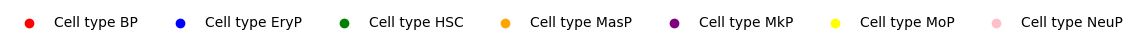

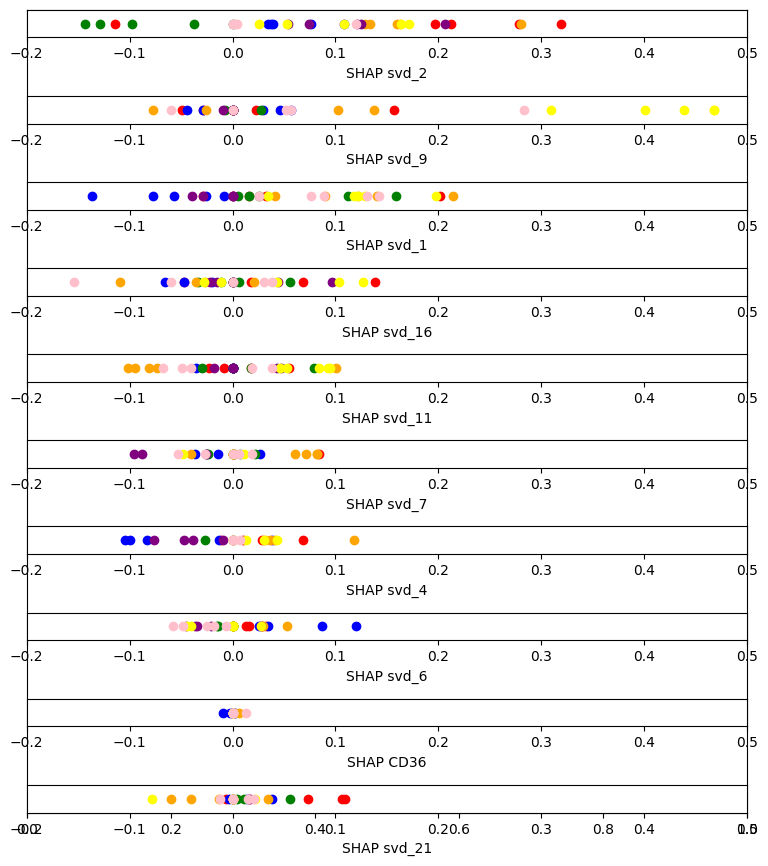

In [125]:
# Assign different colors to each class
colors = {'BP': 'red', 'EryP': 'blue', 'HSC': 'green', 'MasP': 'orange', 'MkP': 'purple', 'MoP': 'yellow', 'NeuP': 'pink'}

## legend ##
legend_fig, legend_ax = plt.subplots(figsize=(2, 2))

for class_label, color in colors.items():
    legend_ax.scatter([], [], color=color, label=f'Cell type {class_label}')

legend_ax.legend(loc='center', bbox_to_anchor=(0.5, 1.2), ncol=len(colors), frameon=False)
legend_ax.axis('off')
## legend ##


# plot shap values:
fig, ax = plt.subplots(figsize=(8, 10))

x_limit = (-0.2, 0.5)

# Remove y-axis ticks and labels
ax.yaxis.set_visible(False)

# Iterate over the columns in shap_cell_types to create subplots
for i, column in enumerate(shap_cell_types.columns[:-1], start=1):

    ax = fig.add_subplot(len(shap_cell_types.columns)-1, 1, i)

    # Set the x-axis limits and label
    ax.set_xlim(x_limit)
    ax.set_xlabel(column)

    ax.yaxis.set_visible(False)

    # Plot the dots for the current column
    for index, row in shap_cell_types.iterrows():
        shap_value = row[column]
        class_label = row['Cell Type']
        color = colors[class_label]
        ax.plot(shap_value, 0, marker='o', color=color)

        
fig.tight_layout(rect=[0, 0.1, 1, 1]) 
legend_fig.subplots_adjust(top=0.1, bottom=0.05)

plt.show()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


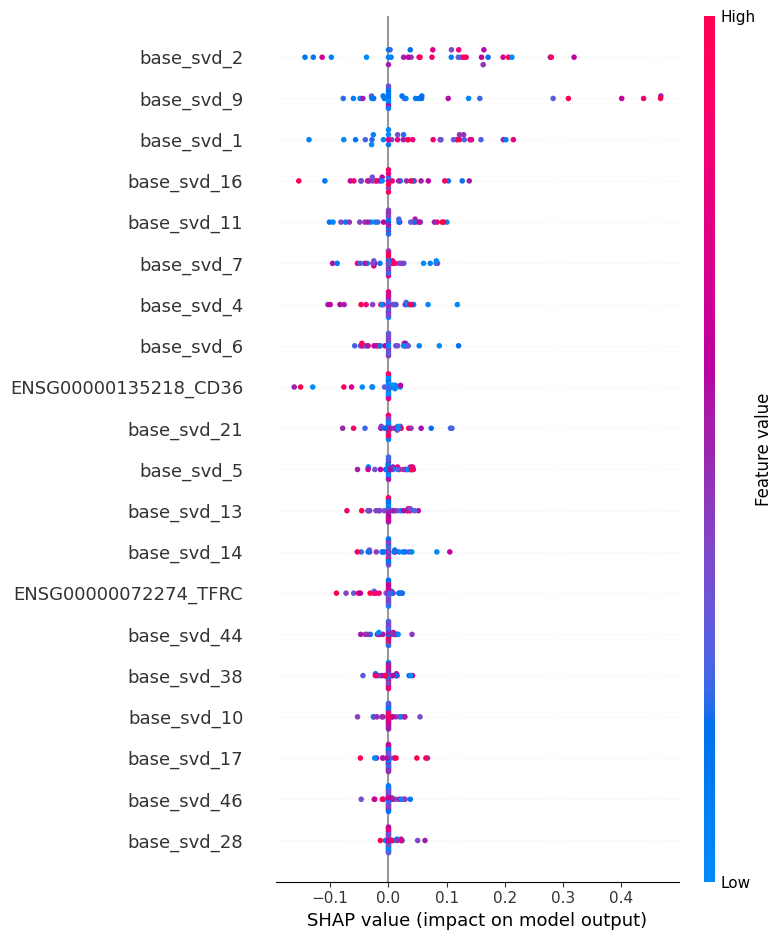

In [55]:
shap.initjs()
shap.summary_plot(shap_values[0], xtest.drop(['cell_id', 'cell_type'], axis=1), feature_names=xtest.drop(['cell_id', 'cell_type'], axis=1).columns)

# goal: get this plot as SHAP / features instead of SHAP / SVD components + features


In [ ]:
shap.initjs()
shap.summary_plot(list(shap_values), plot_type = 'bar', feature_names = xtest.drop(['cell_id', 'cell_type'], axis=1).columns)
# 140 classes = each regression output

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.


### svd contributions:

In [ ]:
svd_comp_norm = np.loadtxt('/dss/dsshome1/02/di93zoj/valentina/open-problems-multimodal-3rd-solution/code/2.preprocess_to_feature/cite/svd_comp_norm.txt', delimiter=',')
print(pd.DataFrame(svd_comp_norm).shape)
pd.DataFrame(svd_comp_norm).head()

(128, 22001)


In [58]:
# base_svd_2 important feature
svd_comp_norm[2]         # => contribution x_2 = -0.00001809 * geneA - 0.00000149 * geneB + 0.0000030917 * geneC + ... + 0.0001264 geneX + 0.00026577 geneY + 0.000175 geneZ

array([-1.80979350e-05, -1.49000311e-06,  3.09174447e-06, ...,
        1.26464845e-04,  2.65770446e-04,  1.75062174e-04])

In [59]:
pd.DataFrame(shap_values[0]).head()

0         1         2         3         4         5         6    \
0 -0.001258 -0.028997  0.196794  0.000000  0.000000  0.000000  0.028894   
1  0.000000  0.032728  0.318743  0.008943  0.010122 -0.013775  0.012584   
2  0.000000  0.015616  0.211980  0.000000  0.028795  0.000000  0.032422   
3  0.000000  0.201583 -0.113936  0.018501 -0.011257 -0.053279  0.015758   
4  0.000000  0.000000  0.278029  0.004335  0.067960  0.015729  0.000000   

        7         8         9         10        11        12        13   \
0  0.000963 -0.007535 -0.028404 -0.026043  0.054919  0.000000  0.000000   
1  0.000000  0.000000  0.023219 -0.019991 -0.008505 -0.010018  0.031958   
2  0.084197  0.000000  0.000000 -0.053274  0.017783  0.000000  0.000000   
3  0.000000  0.000000  0.156891  0.000000 -0.022656  0.000000  0.000000   
4  0.000000  0.000000 -0.048922  0.000000  0.000000  0.000000  0.009522   

        14        15        16        17        18        19        20   \
0 -0.002095 -0.006193  0.068443  0.000000  0.000000  0.000000  0.015090   
1  0.000000  0.000572  0.000000 -0.020723  0.000000  0.000000 -0.013073   
2  0.000000  0.000000 -0.046735  0.000000  0.000000  0.000000  0.000000   
3 -0.011147  0.000000  0.138690  0.010051  0.043733  0.000000  0.000000   
4  0.000000  0.013963  0.017497  0.002480  0.000000 -0.012693 -0.016721   

        21        22        23        24        25        26        27   \
0 -0.006373 -0.009335  0.000000  0.000000  0.000000  0.000000  0.000000   
1  0.015816 -0.010917 -0.009036  0.000000  0.000000  0.001178  0.000000   
2  0.073374  0.000000  0.000000  0.000000  0.000000  0.000000  0.013802   
3  0.108990  0.000000  0.000000  0.000000 -0.015319  0.000000  0.036654   
4  0.106554  0.000000  0.000000 -0.014021  0.000000  0.000000  0.000000   

        28        29       30        31   32        33        34        35   \
0  0.000000 -0.017580  0.00638  0.000000  0.0  0.026073  0.013710  0.000000   
1  0.000000 -0.033049  0.00000  0.015324  0.0 -0.020248  0.000000  0.000000   
2  0.022249  0.000000  0.00000  0.000000  0.0  0.000000  0.000000  0.000000   
3  0.000000 -0.010011  0.00000  0.024444  0.0  0.020651  0.021112 -0.012284   
4  0.008155 -0.003690  0.00000 -0.023268  0.0  0.000000  0.000000 -0.005612   

   36   37        38        39        40        41        42        43   \
0  0.0  0.0  0.000000 -0.003678  0.000000 -0.006961  0.000000  0.015954   
1  0.0  0.0  0.000000  0.015825  0.014286  0.000000  0.018556  0.000000   
2  0.0  0.0  0.041342  0.000000  0.000000  0.000000  0.000000  0.000000   
3  0.0  0.0  0.000000  0.009005 -0.020026  0.032983  0.000000 -0.030865   
4  0.0  0.0  0.035419  0.000000  0.015553 -0.024396  0.000000  0.008308   

        44   45        46        47   48        49   50        51   52   \
0  0.000000  0.0  0.000000  0.014865  0.0 -0.012759  0.0 -0.024475  0.0   
1 -0.014683  0.0  0.000000  0.013365  0.0  0.013166  0.0  0.000000  0.0   
2  0.000000  0.0  0.000000  0.000000  0.0  0.000000  0.0  0.000000  0.0   
3  0.000000  0.0  0.037493  0.000000  0.0  0.037166  0.0 -0.014556  0.0   
4  0.008417  0.0  0.000000  0.000000  0.0 -0.020118  0.0 -0.004116  0.0   

        53        54        55        56        57        58        59   \
0  0.009193  0.011366  0.000000  0.000000  0.010366  0.000000  0.000000   
1  0.033506  0.000000  0.000000  0.000000 -0.010843  0.013713 -0.005361   
2  0.000000  0.000000  0.000000  0.000000  0.000000  0.007650  0.000000   
3  0.011736  0.000000 -0.008324  0.000000  0.000000  0.003202 -0.011319   
4  0.019098  0.000000  0.000000 -0.003134  0.000000  0.016261  0.000000   

       60        61        62   63        64        65   66   67        68   \
0  0.00000  0.000000  0.000000  0.0  0.000000  0.000000  0.0  0.0 -0.007844   
1  0.00000  0.000000  0.000000  0.0  0.000000  0.000000  0.0  0.0  0.000000   
2  0.00000  0.000000  0.000000  0.0  0.000000  0.000000  0.0  0.0  0.000000   
3  0.00000  0.000000  0.019316  0.0 -0.004162  0.059295  0.0

In [60]:
# multiply SHAP(svd_n)*contribution of gene A to component n -> sum
# each dot in summary_plot is attribution for one cell -> loop over all cells

# 212 features: 128 svd and 84 genes
# cells: 35
# predicted "classes": 140

# contribution of gene A to component n: svd_comp_norm
# SHAP(svd_n) for the 128 svd (=first 128 columns)


# TODO delete following at some point, should be represented in next cell as 3D
# attr_genes_only = np.zeros((len(xtest), 22001))  # Initialize the output array, 35x22001

# for cell in range(len(xtest)):
#     for gene in range(22001):
#         attr_gene = 0
#         for svd in range(128):
#             attr_gene += shap_values[0][cell][svd] * svd_comp_norm[svd][gene]   # this is for one cell -> loop over all cells
#         attr_genes_only[cell][gene] = attr_gene
# attr_genes_only

In [61]:
# add third dimension -> 140x35x22001
attr_genes_only = np.zeros((shap_values.shape[0], len(xtest), 22001))  # Initialize the output array, 140x35x22001

for pred in range(shap_values.shape[0]):
    for cell in range(len(xtest)):
        attr_genes_only[pred, cell] = np.sum(shap_values[pred, cell, :128, None] * svd_comp_norm[:128], axis=0)

print(attr_genes_only.shape)
attr_genes_only[0]

array([[ 4.73217407e-06, -3.47333530e-05,  3.75817121e-04, ...,
         4.43387984e-04, -1.25020299e-03, -2.34682679e-04],
       [ 1.35400431e-04,  1.62810242e-04, -1.23668869e-04, ...,
         2.38082110e-04,  5.81653030e-04,  4.25412683e-04],
       [ 3.75104409e-05, -1.49274182e-05, -3.76728242e-06, ...,
         1.74768771e-04,  1.12188808e-03,  1.60043420e-04],
       ...,
       [ 5.16313019e-06,  4.06732603e-05, -1.07736344e-04, ...,
        -5.81096956e-05,  1.71550743e-03,  2.43950447e-04],
       [-1.31906763e-06,  8.46107765e-06,  2.79242547e-05, ...,
         3.49507205e-04, -3.97697592e-05, -1.89920492e-04],
       [ 3.99124051e-05,  1.47412259e-04, -3.82776402e-04, ...,
        -1.47731537e-04, -4.66664902e-03,  1.70772784e-05]])

In [62]:
# load gene names of 22001 genes (excl. 84 handselected genes)
# gene_ids contains gene names of 84 handselected genes
all_genes = np.loadtxt('/dss/dsshome1/02/di93zoj/valentina/open-problems-multimodal-3rd-solution/code/2.preprocess_to_feature/cite/all_genes_names.txt', dtype=str)
all_genes   # len 22001   (excl. the 84 other genes)   -> need list(all_genes) + gene_ids

array(['ENSG00000121410_A1BG', 'ENSG00000268895_A1BG-AS1',
       'ENSG00000175899_A2M', ..., 'ENSG00000162378_ZYG11B',
       'ENSG00000159840_ZYX', 'ENSG00000074755_ZZEF1'], dtype='<U41')

In [ ]:
# create attr_all_22085_genes: pass gene and cell names -> for shap plot, "new shap values" with backpropagated svd weights
attr_all_22085_genes = np.hstack((attr_genes_only[0], shap_values[0][:,-84:]))
print(pd.DataFrame(attr_all_22085_genes, columns=list(all_genes)+gene_ids).shape)
pd.DataFrame(attr_all_22085_genes, columns=list(all_genes)+gene_ids).head()

(35, 22085)


In [ ]:
test_inputs = scipy.sparse.load_npz(index_path + "test_cite_raw_inputs_values.sparse.npz")
test_inputs = pd.DataFrame(test_inputs.toarray(), columns=list(all_genes)+gene_ids)

# get cell ids
test_ids = np.load(index_path + "test_cite_raw_inputs_idxcol.npz", allow_pickle=True)
test_index = test_ids["index"]
len(test_index)

test_inputs.index = test_index

test_inputs

ENSG00000121410_A1BG  ENSG00000268895_A1BG-AS1  \
83d6659a6a32                   0.0                       0.0   
d98594f13d2e                   0.0                       0.0   
5f93d8ffc72f                   0.0                       0.0   
7dfa2699d351                   0.0                       0.0   
6d2533edd0e0                   0.0                       0.0   
...                            ...                       ...   
a9b4d99f1f50                   0.0                       0.0   
0e2c1d0782af                   0.0                       0.0   
a3cbc5aa0ec3                   0.0                       0.0   
75b350243add                   0.0                       0.0   
ad5a949989b2                   0.0                       0.0   

              ENSG00000175899_A2M  ENSG00000245105_A2M-AS1  \
83d6659a6a32                  0.0                      1.0   
d98594f13d2e                  0.0                      0.0   
5f93d8ffc72f                  0.0                      0.0   
7dfa2699d351                  0.0                      0.0   
6d2533edd0e0                  0.0                      0.0   
...                           ...                      ...   
a9b4d99f1f50                  0.0                      0.0   
0e2c1d0782af                  0.0                      0.0   
a3cbc5aa0ec3                  0.0                      0.0   
75b350243add                  0.0                      0.0   
ad5a949989b2                  0.0                      0.0   

              ENSG00000166535_A2ML1  ENSG00000128274_A4GALT  \
83d6659a6a32                    0.0                     0.0   
d98594f13d2e                    0.0                     0.0   
5f93d8ffc72f                    0.0                     0.0   
7dfa2699d351                    0.0                     0.0   
6d2533edd0e0                    0.0                     0.0   
...                             ...                     ...   
a9b4d99f1f50                    0.0                     0.0   
0e2c1d0782af                    0.0                     0.0   
a3cbc5aa0ec3                    0.0                     0.0   
75b350243add                    0.0                     0.0   
ad5a949989b2                    0.0                     0.0   

              ENSG00000094914_AAAS  ENSG00000081760_AACS  \
83d6659a6a32                   3.0                   2.0   
d98594f13d2e                   1.0                   1.0   
5f93d8ffc72f                   0.0                   2.0   
7dfa2699d351                   1.0                   2.0   
6d2533edd0e0                   0.0                   0.0   
...                            ...                   ...   
a9b4d99f1f50                   0.0                   0.0   
0e2c1d0782af                   0.0                   0.0   
a3cbc5aa0ec3                   0.0                   0.0   
75b350243add                   1.0                   1.0   
ad5a949989b2                   0.0                   3.0   

              ENSG00000109576_AADAT  ENSG00000103591_AAGAB  \
83d6659a6a32                    1.0                    0.0   
d98594f13d2e                    0.0                    2.0   
5f93d8ffc72f                    0.0                    1.0   
7dfa2699d351                    0.0                    1.0   
6d2533edd0e0                    0.0                    0.0   
...                             ...                    ...   
a9b4d99f1f50                    0.0                    1.0   
0e2c1d0782af                    1.0                    0.0   
a3cbc5aa0ec3                    0.0                    0.0   
75b350243add                    0.0                    0.0   
ad5a949989b2                    0.0                    1.0   

              ENSG00000115977_AAK1  ENSG00000087884_AAMDC  \
83d6659a6a32                   2.0                    1.0   
d98594f13d2e                   2.0                    2.0   
5f93d8ffc72f                   4.0                    1.0   
7dfa2699d351                   1.

In [65]:
# cell ids used in xtest and SHAP:
sample_cells = np.array(xtest['cell_id'])
sample_cells

array(['46a536d2aba8', 'fc907e30e1c7', '6c3abb20aa12', '7798cfe1a4a7',
       'f507be21e97c', '3e16a74f4d2f', '4d371765b14b', 'abf31c93911d',
       'f5a6b610f488', 'd43d5ef0a33b', '8fcaf3ddf2bb', '951e9a5a90aa',
       '7b496b460c2c', 'f22c12d432ed', 'e2f7fc07fed4', 'e290b00ff3b8',
       'e7c1d82f057f', '6107dcae193c', '33362d01572b', '269d3240be7b',
       '4bba71ad0b21', '20936e07d76f', 'cdd46ca8923f', '40312c07d49d',
       'eb249c074c13', '1582e62f3ac2', 'f13aec72581d', '83c2b67b9e75',
       '740f9f84981a', '18e3f0dcc344', '3903826e64de', '431f562843bb',
       '769a0c7c7016', 'e6f534aef99b', '4a302c644b9f'], dtype=object)

In [66]:
# create xtest_all_genes: for shap plot, containing all 22085 genes instead of svd components
xtest_all_genes = test_inputs.loc[sample_cells]
print(xtest_all_genes.shape)
xtest_all_genes.head()

(35, 22085)


ENSG00000121410_A1BG  ENSG00000268895_A1BG-AS1  \
46a536d2aba8                   0.0                       0.0   
fc907e30e1c7                   0.0                       0.0   
6c3abb20aa12                   0.0                       0.0   
7798cfe1a4a7                   0.0                       0.0   
f507be21e97c                   0.0                       0.0   

              ENSG00000175899_A2M  ENSG00000245105_A2M-AS1  \
46a536d2aba8                  0.0                      0.0   
fc907e30e1c7                  0.0                      0.0   
6c3abb20aa12                  0.0                      0.0   
7798cfe1a4a7                  0.0                      0.0   
f507be21e97c                  0.0                      0.0   

              ENSG00000166535_A2ML1  ENSG00000128274_A4GALT  \
46a536d2aba8                    0.0                     0.0   
fc907e30e1c7                    0.0                     0.0   
6c3abb20aa12                    0.0                     0.0   
7798cfe1a4a7                    0.0                     0.0   
f507be21e97c                    0.0                     0.0   

              ENSG00000094914_AAAS  ENSG00000081760_AACS  \
46a536d2aba8                   0.0                   0.0   
fc907e30e1c7                   0.0                   0.0   
6c3abb20aa12                   0.0                   0.0   
7798cfe1a4a7                   0.0                   2.0   
f507be21e97c                   3.0                   0.0   

              ENSG00000109576_AADAT  ENSG00000103591_AAGAB  \
46a536d2aba8                    0.0                    0.0   
fc907e30e1c7                    0.0                    1.0   
6c3abb20aa12                    0.0                    0.0   
7798cfe1a4a7                    0.0                    0.0   
f507be21e97c                    0.0                    0.0   

              ENSG00000115977_AAK1  ENSG00000087884_AAMDC  \
46a536d2aba8                   1.0                    0.0   
fc907e30e1c7                   3.0                    2.0   
6c3abb20aa12                   0.0                    0.0   
7798cfe1a4a7                   1.0                    1.0   
f507be21e97c                   1.0                    1.0   

              ENSG00000127837_AAMP  ENSG00000129673_AANAT  \
46a536d2aba8                   0.0                    0.0   
fc907e30e1c7                   5.0                    0.0   
6c3abb20aa12                   0.0                    0.0   
7798cfe1a4a7                   0.0                    0.0   
f507be21e97c                   2.0                    0.0   

              ENSG00000131043_AAR2  ENSG00000205002_AARD  \
46a536d2aba8                   0.0                   0.0   
fc907e30e1c7                   0.0                   0.0   
6c3abb20aa12                   0.0                   0.0   
7798cfe1a4a7                   0.0                   0.0   
f507be21e97c                   0.0                   0.0   

              ENSG00000090861_AARS  ENSG00000124608_AARS2  \
46a536d2aba8                   2.0                    1.0   
fc907e30e1c7                   1.0                    0.0   
6c3abb20aa12                   2.0                    0.0   
7798cfe1a4a7                   1.0                    1.0   
f507be21e97c                   2.0                    0.0   

              ENSG00000266967_AARSD1  ENSG00000157426_AASDH  \
46a536d2aba8                     0.0                    0.0   
fc907e30e1c7                     0.0                    0.0   
6c3abb20aa12                     0.0                    0.0   
7798cfe1a4a7                     0.0                    0.0   
f507be21e97c                     0.0                    0.0   

              ENSG00000149313_AASDHPPT  ENSG00000008311_AASS  \
46a536d2aba8                       4.0                   0.0   
fc907e30e1c7                       2.0                   0.0   
6c3abb20aa12                       0.0                   0.0   
7798cfe1a4a7                       4.0        

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


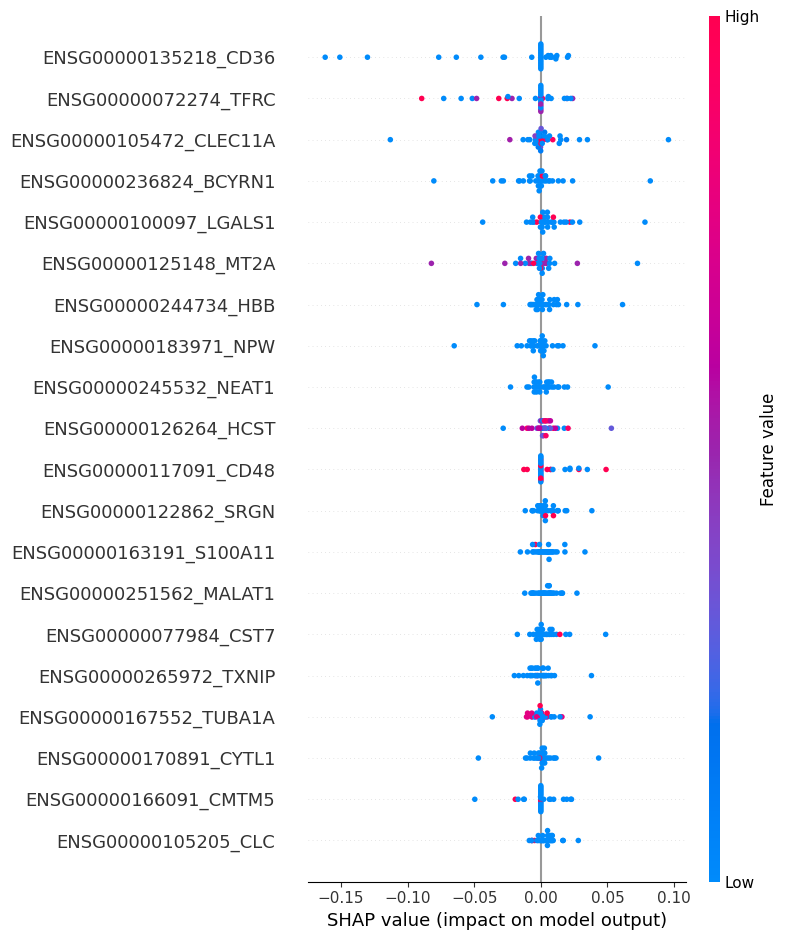

In [67]:
shap.initjs()
shap.summary_plot(attr_all_22085_genes, xtest_all_genes, feature_names=xtest_all_genes.columns)

In [68]:
# top 20 genes:
shap_sum = np.abs(attr_all_22085_genes).sum(axis=0)
top_features_indices = np.argsort(shap_sum)[::-1][:20]  # Get the indices of the top 20 features
top_feature_names_shap = xtest_all_genes.columns[top_features_indices]
top_feature_names_shap

Index(['ENSG00000135218_CD36', 'ENSG00000072274_TFRC',
       'ENSG00000105472_CLEC11A', 'ENSG00000236824_BCYRN1',
       'ENSG00000100097_LGALS1', 'ENSG00000125148_MT2A', 'ENSG00000244734_HBB',
       'ENSG00000183971_NPW', 'ENSG00000245532_NEAT1', 'ENSG00000126264_HCST',
       'ENSG00000117091_CD48', 'ENSG00000122862_SRGN',
       'ENSG00000163191_S100A11', 'ENSG00000251562_MALAT1',
       'ENSG00000077984_CST7', 'ENSG00000265972_TXNIP',
       'ENSG00000167552_TUBA1A', 'ENSG00000170891_CYTL1',
       'ENSG00000166091_CMTM5', 'ENSG00000105205_CLC'],
      dtype='object')

In [69]:
# This cell shows that the top 20 attributing genes are from both the handselected and the other genes with similar distribution
for gene in top_feature_names_shap:
    if gene in list(all_genes):
        print(gene, 'among 22001 genes.')
    if gene in gene_ids:
        print(gene, 'among handselected 84 genes.')

ENSG00000135218_CD36 among handselected 84 genes.
ENSG00000072274_TFRC among handselected 84 genes.
ENSG00000105472_CLEC11A among 22001 genes.
ENSG00000236824_BCYRN1 among 22001 genes.
ENSG00000100097_LGALS1 among 22001 genes.
ENSG00000125148_MT2A among 22001 genes.
ENSG00000244734_HBB among 22001 genes.
ENSG00000183971_NPW among 22001 genes.
ENSG00000245532_NEAT1 among 22001 genes.
ENSG00000126264_HCST among 22001 genes.
ENSG00000117091_CD48 among handselected 84 genes.
ENSG00000122862_SRGN among 22001 genes.
ENSG00000163191_S100A11 among 22001 genes.
ENSG00000251562_MALAT1 among 22001 genes.
ENSG00000077984_CST7 among 22001 genes.
ENSG00000265972_TXNIP among 22001 genes.
ENSG00000167552_TUBA1A among 22001 genes.
ENSG00000170891_CYTL1 among 22001 genes.
ENSG00000166091_CMTM5 among handselected 84 genes.
ENSG00000105205_CLC among 22001 genes.


### analyze gene attribution distributions

In [70]:
abs_mean_attributions = np.mean(np.abs(attr_all_22085_genes), axis=0)

distribution = np.histogram(abs_mean_attributions, bins=10)

print("Distribution of absolute values of mean attributions per gene for all genes:")
for value, count in zip(distribution[1], distribution[0]):
    print("Range: {:.5f} - {:.5f}, Count: {}".format(value, value + distribution[1][1], count))

Distribution of absolute values of mean attributions per gene for all genes:
Range: 0.00000 - 0.00228, Count: 21230
Range: 0.00228 - 0.00456, Count: 794
Range: 0.00456 - 0.00684, Count: 49
Range: 0.00684 - 0.00912, Count: 5
Range: 0.00912 - 0.01140, Count: 3
Range: 0.01140 - 0.01368, Count: 2
Range: 0.01368 - 0.01596, Count: 0
Range: 0.01596 - 0.01823, Count: 1
Range: 0.01823 - 0.02051, Count: 0
Range: 0.02051 - 0.02279, Count: 1


In [71]:
abs_mean_attributions_others = np.mean(np.abs(attr_all_22085_genes[:, :22001]), axis=0)

# log_bins = np.logspace(np.log2(abs_mean_attributions.min() + 1e-9), np.log2(abs_mean_attributions.max()), 10)  # for plot 

distribution_others = np.histogram(abs_mean_attributions_others, bins=distribution[1])  # bins=log_bins  # 10

print("Distribution of absolute values of mean attributions per column of 22001 genes:")
for value, count in zip(distribution_others[1], distribution_others[0]):
    print("Range: {:.5f} - {:.5f}, Count: {}".format(value, value + distribution_others[1][1], count))

# get top attributing genes
genes_higher_attr_others_idx = np.where(abs_mean_attributions_others >= 0.00766)[0]
print(genes_higher_attr_others_idx)
genes_higher_attr_others = all_genes[genes_higher_attr_others_idx]
genes_higher_attr_others

Distribution of absolute values of mean attributions per column of 22001 genes:
Range: 0.00000 - 0.00228, Count: 21185
Range: 0.00228 - 0.00456, Count: 764
Range: 0.00456 - 0.00684, Count: 43
Range: 0.00684 - 0.00912, Count: 4
Range: 0.00912 - 0.01140, Count: 3
Range: 0.01140 - 0.01368, Count: 2
Range: 0.01368 - 0.01596, Count: 0
Range: 0.01596 - 0.01823, Count: 0
Range: 0.01823 - 0.02051, Count: 0
Range: 0.02051 - 0.02279, Count: 0
[ 5759  7177 10314 11796 13369 13816 14101]


array(['ENSG00000236824_BCYRN1', 'ENSG00000105472_CLEC11A',
       'ENSG00000244734_HBB', 'ENSG00000100097_LGALS1',
       'ENSG00000125148_MT2A', 'ENSG00000245532_NEAT1',
       'ENSG00000183971_NPW'], dtype='<U41')

In [72]:
abs_mean_attributions_handselected = np.mean(np.abs(attr_all_22085_genes[:, -84:]), axis=0)

# log_bins = np.logspace(np.log2(abs_mean_attributions.min() + 1e-9), np.log2(abs_mean_attributions.max()), 10)

distribution_handselected = np.histogram(abs_mean_attributions_handselected, bins=10)  # bins=log_bins

print("Distribution of absolute values of mean attributions per handselected gene:")
for value, count in zip(distribution_handselected[1], distribution_handselected[0]):
    print("Range: {:.5f} - {:.5f}, Count: {}".format(value, value + distribution_handselected[1][1], count))

# get genes with count 1 (top attributing genes)
genes_higher_attr_handselected_idx = np.where(abs_mean_attributions_handselected >= 0.00684)[0]
print(genes_higher_attr_handselected_idx)
genes_higher_attr_handselected = [gene_ids[idx] for idx in genes_higher_attr_handselected_idx]
genes_higher_attr_handselected

Distribution of absolute values of mean attributions per handselected gene:
Range: 0.00000 - 0.00228, Count: 45
Range: 0.00228 - 0.00456, Count: 30
Range: 0.00456 - 0.00684, Count: 6
Range: 0.00684 - 0.00912, Count: 1
Range: 0.00912 - 0.01140, Count: 0
Range: 0.01140 - 0.01368, Count: 0
Range: 0.01368 - 0.01596, Count: 0
Range: 0.01596 - 0.01823, Count: 1
Range: 0.01823 - 0.02051, Count: 0
Range: 0.02051 - 0.02279, Count: 1
[20 24 80]


['ENSG00000135218_CD36', 'ENSG00000117091_CD48', 'ENSG00000072274_TFRC']

In [73]:
print(abs_mean_attributions_handselected.tolist().index(0))
gene_ids[14]

14


'ENSG00000206531_CD200R1L'

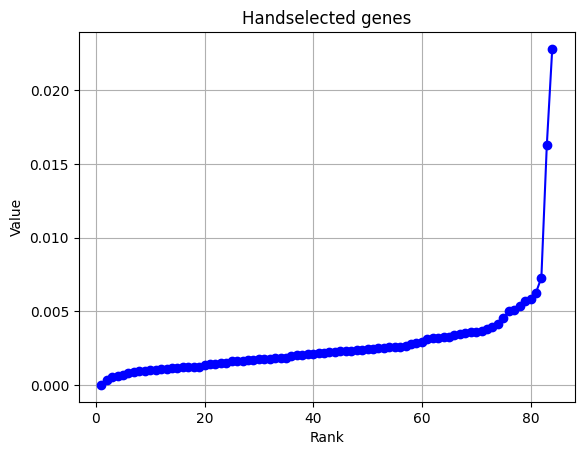

In [74]:
values = np.sort(abs_mean_attributions_handselected)
ranks = np.arange(1, len(values) + 1)

plt.plot(ranks, values, marker='o', linestyle='-', color='blue')
plt.xlabel('Rank')
plt.ylabel('Value')
plt.title('Handselected genes')
plt.grid(True)
plt.show()

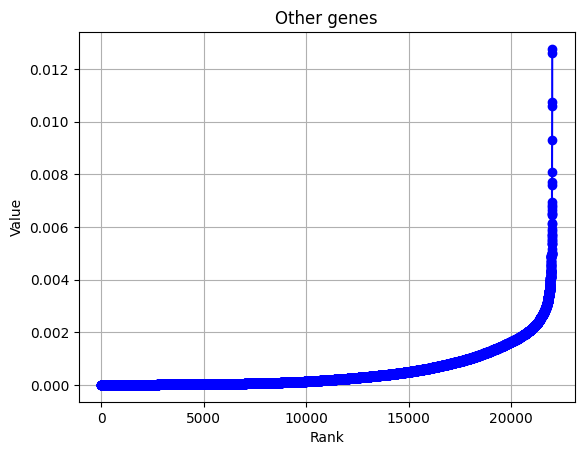

In [75]:
values = np.sort(abs_mean_attributions_others)
ranks = np.arange(1, len(values) + 1)

plt.plot(ranks, values, marker='o', linestyle='-', color='blue')
plt.xlabel('Rank')
plt.ylabel('Value')
plt.title('Other genes')
plt.grid(True)
plt.show()

In [76]:
# TODO plot these in one plot: seaborn scatterplot hue

In [77]:
# get abs_mean_attribution == 0
#print(np.sort(abs_mean_attributions_handselected))
#print(np.sort(abs_mean_attributions_others)[:500])

In [78]:
for i in genes_higher_attr_others:
    print(i in top_feature_names_shap)

for i in genes_higher_attr_handselected:
    print(i in top_feature_names_shap)

True
True
True
True
True
True
True
True
True
True


In [79]:
# TODO add label of gini index per plot
def gini(arr):    # range from 0 (total equality) to 1 (absolute inequality)
    ## first sort
    sorted_arr = arr.copy()
    sorted_arr.sort()
    n = arr.size
    coef_ = 2. / n
    const_ = (n + 1.) / n
    weighted_sum = sum([(i+1)*yi for i, yi in enumerate(sorted_arr)])
    return coef_*weighted_sum/(sorted_arr.sum()) - const_

print(gini(abs_mean_attributions_handselected))
print(gini(abs_mean_attributions_others))


# TODO put plots into one with same y-axis scale

0.3988689912906416
0.660323323362501


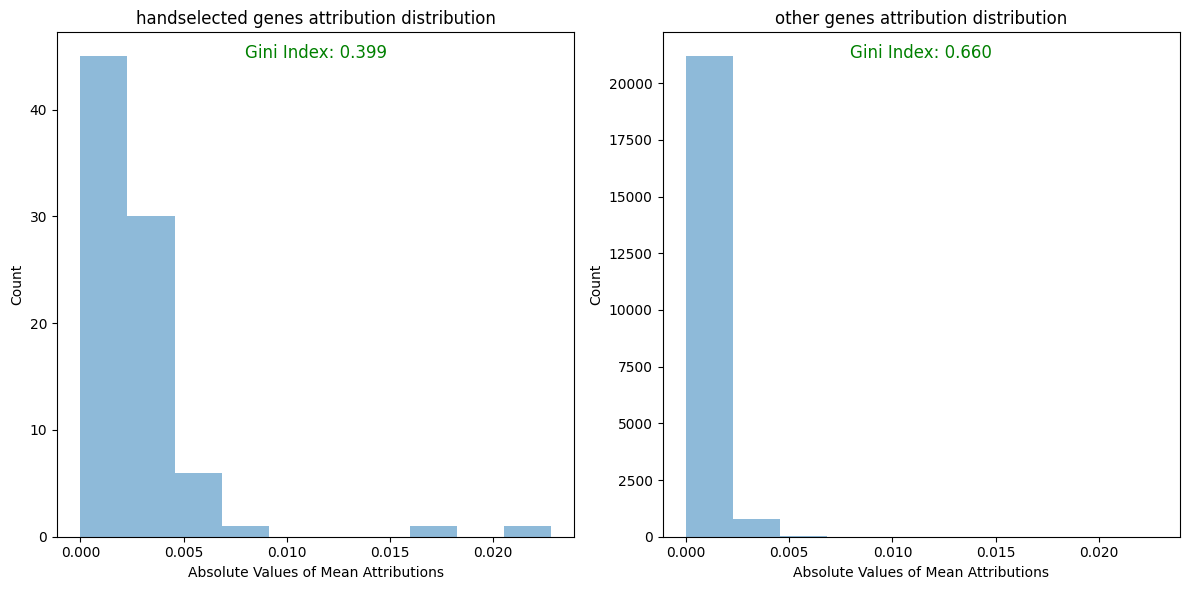

In [80]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.hist(abs_mean_attributions_handselected, bins=distribution[1], alpha=0.5)  # bins=distribution[1]  # bins=log_bins
# ax1.set_xscale('log')
ax1.text(0.5, 0.95, f'Gini Index: {gini(abs_mean_attributions_handselected):.3f}', transform=ax1.transAxes, ha='center', color='green', fontsize=12)

ax1.set_xlabel('Absolute Values of Mean Attributions')
ax1.set_ylabel('Count')
ax1.set_title('handselected genes attribution distribution')

ax2.hist(abs_mean_attributions_others, bins=distribution[1], alpha=0.5)
# ax2.set_xscale('log')
ax2.text(0.5, 0.95, f'Gini Index: {gini(abs_mean_attributions_others):.3f}', transform=ax2.transAxes, ha='center', color='green', fontsize=12)

ax2.set_xlabel('Absolute Values of Mean Attributions')
ax2.set_ylabel('Count')
ax2.set_title('other genes attribution distribution')

plt.tight_layout()
plt.show()

(0.0, 22244.25)


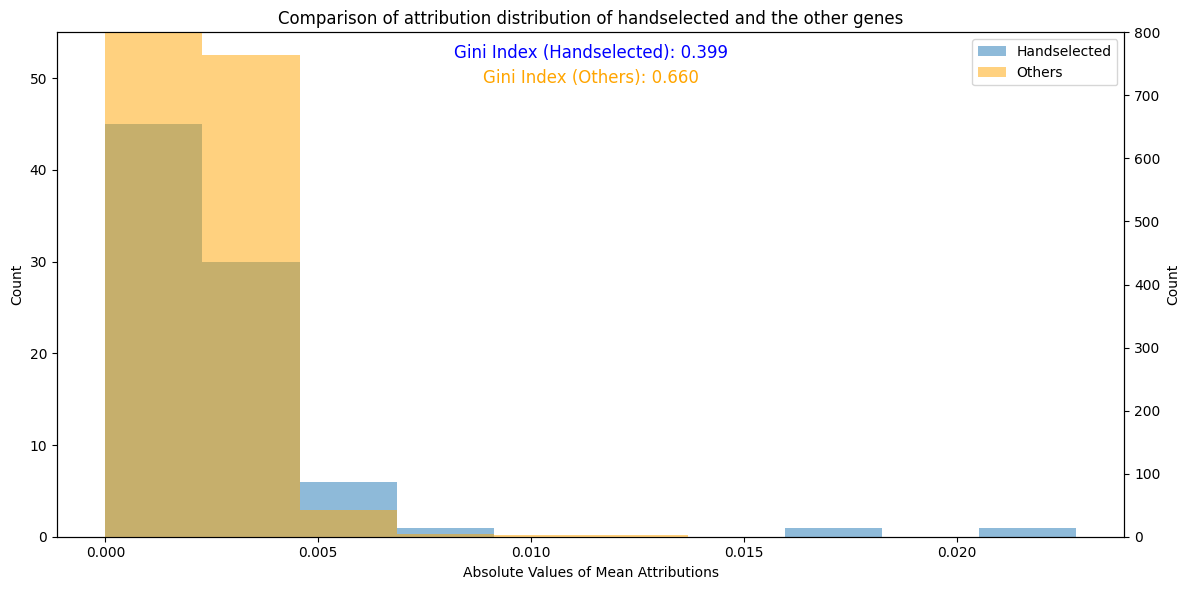

In [81]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.hist(abs_mean_attributions_handselected, bins=distribution[1], alpha=0.5, label='Handselected')
ax.set_xlabel('Absolute Values of Mean Attributions')
ax.set_ylabel('Count')
ax.set_title('Comparison of attribution distribution of handselected and the other genes')

# Create a twin axis for the second histogram
ax2 = ax.twinx()

ax2.hist(abs_mean_attributions_others, bins=distribution[1], alpha=0.5, color='orange', label='Others')
ax2.set_ylabel('Count')

# Adjust the y-axis limits of the twin Axes to match the primary Axes
# ax.set_ylim(ax2.get_ylim())
print(ax2.get_ylim())
ax.set_ylim((0,55))
ax2.set_ylim((0,800))

# Add legend
handles, labels = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax.legend(handles + handles2, labels + labels2, loc='upper right')

# Add Gini index labels
ax.text(0.5, 0.95, f'Gini Index (Handselected): {gini(abs_mean_attributions_handselected):.3f}', transform=ax.transAxes, ha='center', color='blue', fontsize=12)
ax2.text(0.5, 0.90, f'Gini Index (Others): {gini(abs_mean_attributions_others):.3f}', transform=ax2.transAxes, ha='center', color='orange', fontsize=12)

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

In [82]:
# TODO same density for both plots (same area of histograms) -> adjusts y-axes

In [83]:
# analyze svd components distr.

mean_svd_contr = np.mean(np.abs(svd_comp_norm), axis=0)
top_20_indices = np.argsort(mean_svd_contr)[-20:][::-1]

top_20_mean_contributions = mean_svd_contr[top_20_indices]
top_features_svd = []

# Print the top 20 columns and their mean contributionsb
print("Top 20 Columns with Highest Mean Contributions to SVDs:")
for column_index, mean_contribution in zip(top_20_indices, top_20_mean_contributions):
    print("Column: {}, Mean Contribution: {}".format(all_genes[column_index], mean_contribution))
    top_features_svd.append(all_genes[column_index])
# top_features_svd

Top 20 Columns with Highest Mean Contributions to SVDs:
Column: ENSG00000183971_NPW, Mean Contribution: 0.05371263880033439
Column: ENSG00000265972_TXNIP, Mean Contribution: 0.05304467293306914
Column: ENSG00000184897_H1FX, Mean Contribution: 0.050361890191894076
Column: ENSG00000100097_LGALS1, Mean Contribution: 0.04478373777794786
Column: ENSG00000244734_HBB, Mean Contribution: 0.04448112404531912
Column: ENSG00000170891_CYTL1, Mean Contribution: 0.04375964055004289
Column: ENSG00000125148_MT2A, Mean Contribution: 0.04370106634189597
Column: ENSG00000124766_SOX4, Mean Contribution: 0.043334829030293065
Column: ENSG00000196565_HBG2, Mean Contribution: 0.04226584332002403
Column: ENSG00000136997_MYC, Mean Contribution: 0.04127837825257075
Column: ENSG00000105472_CLEC11A, Mean Contribution: 0.03861755490861185
Column: ENSG00000143013_LMO4, Mean Contribution: 0.03811856453020823
Column: ENSG00000147872_PLIN2, Mean Contribution: 0.03761395295751413
Column: ENSG00000137193_PIM1, Mean Contr

In [84]:
# compare resulting genes
for i in top_features_svd:
    if i in top_feature_names_shap:
        print(i, 'among top 20 shap features')
    
    elif i in genes_higher_attr_handselected:
        print(i, 'among handselected genes with highest attributions')
    elif i in genes_higher_attr_others:
        print(i, 'among other genes with highest attributions')
    else:
        print(i)

ENSG00000183971_NPW among top 20 shap features
ENSG00000265972_TXNIP among top 20 shap features
ENSG00000184897_H1FX
ENSG00000100097_LGALS1 among top 20 shap features
ENSG00000244734_HBB among top 20 shap features
ENSG00000170891_CYTL1 among top 20 shap features
ENSG00000125148_MT2A among top 20 shap features
ENSG00000124766_SOX4
ENSG00000196565_HBG2
ENSG00000136997_MYC
ENSG00000105472_CLEC11A among top 20 shap features
ENSG00000143013_LMO4
ENSG00000147872_PLIN2
ENSG00000137193_PIM1
ENSG00000101745_ANKRD12
ENSG00000160888_IER2
ENSG00000167552_TUBA1A among top 20 shap features
ENSG00000105205_CLC among top 20 shap features
ENSG00000236824_BCYRN1 among top 20 shap features
ENSG00000245532_NEAT1 among top 20 shap features


In [85]:
# 50 per cell type (after test run below) 1
# private_test_target & private_test_input 0
# feed test set to shap instead of 35 samples -> sample x pr cell type from test set
# target test set: double check predictions above

In [86]:
# scanpy clustering 3
# 140 35 212
# per cell type avg across 35 rows -> 140x212 matrix
# -> cluster 140 rows -> 
# clusters of proteins with similar attributions

### shap model #16 for private test data

In [87]:
model

CiteModel(
  (layer_seq_256): Sequential(
    (0): Linear(in_features=212, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=128, bias=True)
    (2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (3): ReLU()
  )
  (layer_seq_64): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=32, bias=True)
    (2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    (3): ReLU()
  )
  (layer_seq_8): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): Linear(in_features=16, out_features=8, bias=True)
    (2): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
    (3): ReLU()
  )
  (head): Linear(in_features=168, out_features=140, bias=True)
)

In [88]:
#X_train_p = pickle.load(open('/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93zoj/kaggle/full_data/20220830_citeseq_rna_count_train.pkl', 'rb'))
#X_train_p = np.array(X_train_p)

X_test_p = ad.read_h5ad('private_test_input_sample.h5ad')

# print('X_train: ', X_train_p.shape)
print('X_test: ', X_test_p.X.shape)

## explainer = shap.KernelExplainer(model, shap.sample(X_train_p, 1000))
## explainer  # use same explainer trained above (?)

# shap_values = explainer.shap_values(X_test_p.X, nsamples=300)

X_test:  (35, 212)


In [89]:
# np.save('shap_values_16_p.npy', np.array(shap_values, dtype=object), allow_pickle=True)

In [99]:
shap_values_16_p = np.load('shap_values_16_p.npy', allow_pickle=True).astype('float')

In [91]:
X_test_p.var_names = new_columns[1:213]   # new_column already implemented for shap plots above

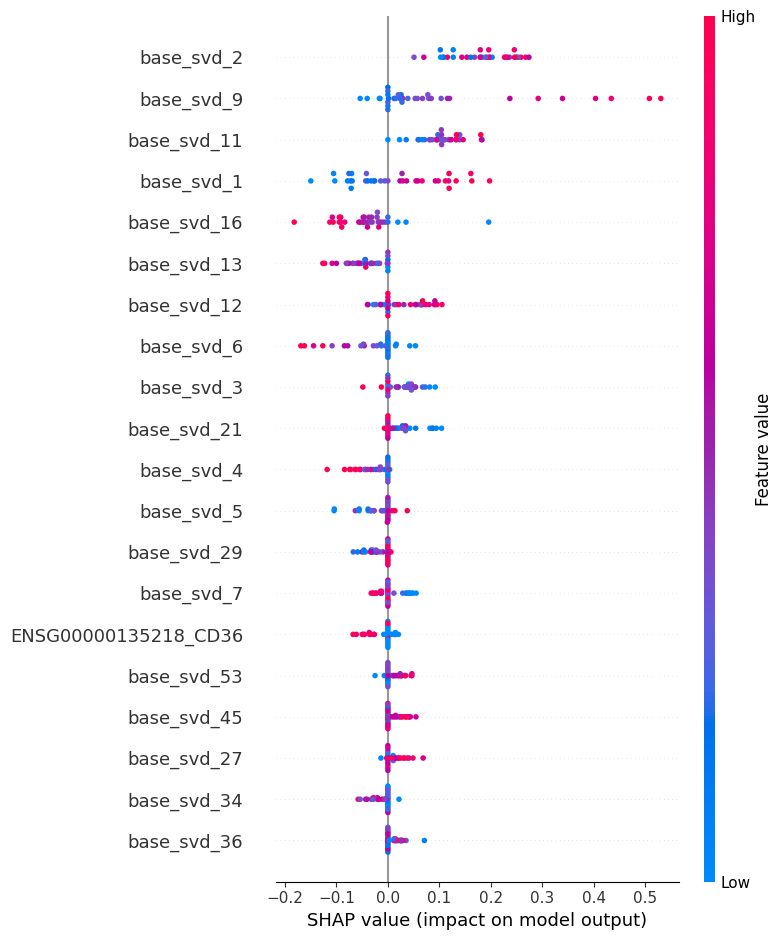

In [100]:
shap.initjs()
shap.summary_plot(shap_values_16_p[0], X_test_p.X, feature_names=X_test_p.var_names)

#### backpropagate svd components

In [101]:
attr_genes_only = np.zeros((shap_values_16_p.shape[0], len(X_test_p.X), 22001))  # Initialize the output array, 140x35x22001

for pred in range(shap_values_16_p.shape[0]):
    for cell in range(len(xtest)):
        attr_genes_only[pred, cell] = np.sum(shap_values_16_p[pred, cell, :128, None] * svd_comp_norm[:128], axis=0)

print(attr_genes_only.shape)
attr_genes_only[0]

(140, 35, 22001)


array([[ 1.56779475e-04,  5.45920292e-04, -5.57555692e-04, ...,
        -9.62244307e-04, -1.60447770e-02,  4.15615856e-04],
       [-7.68222290e-06,  1.78289837e-05,  1.34836695e-04, ...,
        -5.96112647e-05, -9.98443216e-04, -1.16093908e-04],
       [ 5.41547821e-05,  1.06362556e-04, -6.30841056e-04, ...,
        -2.56433175e-04, -4.25490703e-03, -1.78311968e-04],
       ...,
       [ 3.60412824e-05, -1.11113827e-04, -4.34657227e-04, ...,
         1.07580104e-03, -2.28451244e-03, -8.73952794e-04],
       [ 1.17271545e-04,  4.23802104e-05,  9.72467264e-05, ...,
         3.98450204e-04,  1.53705641e-03,  2.08413503e-04],
       [ 2.60942659e-05, -1.33061396e-04, -1.25231048e-04, ...,
         6.41785087e-05, -2.43136021e-03,  2.94216826e-04]])

In [102]:
# create attr_all_22085_genes: pass gene and cell names -> for shap plot, "new shap values" with backpropagated svd weights
attr_all_22085_genes = np.hstack((attr_genes_only[0], shap_values_16_p[0][:,-84:]))
print(pd.DataFrame(attr_all_22085_genes, columns=list(all_genes)+gene_ids).shape)
pd.DataFrame(attr_all_22085_genes, columns=list(all_genes)+gene_ids).head()

(35, 22085)


ENSG00000121410_A1BG  ENSG00000268895_A1BG-AS1  ENSG00000175899_A2M  \
0              0.000157                  0.000546            -0.000558   
1             -0.000008                  0.000018             0.000135   
2              0.000054                  0.000106            -0.000631   
3             -0.000056                  0.000199             0.000108   
4              0.000242                  0.000393            -0.000518   

   ENSG00000245105_A2M-AS1  ENSG00000166535_A2ML1  ENSG00000128274_A4GALT  \
0                 0.000726           3.145294e-05                0.000392   
1                 0.000037          -2.296900e-07               -0.000028   
2                -0.000061           1.229266e-05                0.000313   
3                -0.000072          -1.294243e-05               -0.000138   
4                -0.000088           2.489064e-05                0.000892   

   ENSG00000094914_AAAS  ENSG00000081760_AACS  ENSG00000109576_AADAT  \
0              0.000994              0.007399               0.000465   
1             -0.000036              0.000049              -0.000168   
2             -0.000672              0.002738               0.000068   
3              0.000227              0.001418              -0.000101   
4             -0.001980              0.006275               0.000002   

   ENSG00000103591_AAGAB  ENSG00000115977_AAK1  ENSG00000087884_AAMDC  \
0               0.001046              0.002253              -0.001374   
1               0.000183             -0.001999              -0.000757   
2               0.000011             -0.001731              -0.003472   
3               0.000240              0.000872              -0.000142   
4               0.000578              0.000376              -0.000099   

   ENSG00000127837_AAMP  ENSG00000129673_AANAT  ENSG00000131043_AAR2  \
0              0.001988               0.000144              0.000117   
1              0.000601               0.000001              0.000111   
2              0.000344               0.000007              0.000171   
3              0.000653               0.000007             -0.000260   
4             -0.000434               0.000003             -0.000683   

   ENSG00000205002_AARD  ENSG00000090861_AARS  ENSG00000124608_AARS2  \
0             -0.000397             -0.001998              -0.000758   
1             -0.000139              0.000874               0.000024   
2             -0.000383              0.001554              -0.000336   
3             -0.000244              0.001023              -0.000073   
4             -0.000262              0.001767              -0.000340   

   ENSG00000266967_AARSD1  ENSG00000157426_AASDH  ENSG00000149313_AASDHPPT  \
0                0.000928               0.001065                 -0.003251   
1               -0.000041               0.000035                  0.000330   
2                0.000576              -0.001179                 -0.001158   
3                0.000042              -0.000840                 -0.000397   
4                0.000514              -0.001217                 -0.001529   

   ENSG00000008311_AASS  ENSG00000215458_AATBC  ENSG00000275700_AATF  \
0              0.000044              -0.000022             -0.008656   
1             -0.000089              -0.000014              0.001937   
2             -0.000195              -0.000048             -0.000210   
3             -0.000104              -0.000027              0.002002   
4             -0.000193              -0.000013              0.000401   

   ENSG00000181409_AATK  ENSG00000281376_ABALON  ENSG00000183044_ABAT  \
0              0.000333               -0.000122             -0.000032   
1             -0.000016               -0.000030             -0.000123   
2              0.000174               -0.000046             -0.000171   
3             -0.000027               -0.000032             -0.000076   
4              0.000107                0.000012              0.000437   

   ENSG000001650

In [114]:
# TODO private_test_input instead?
private_test_input_raw = pickle.load(open('/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93zoj/kaggle/full_data/20220830_citeseq_rna_count_test_input_private_raw.pkl', 'rb'))
private_test_input_raw.head()

gene_ids                         ENSG00000121410_A1BG  \
CATAAGCAGCATGATA-1-('27678', 7)                   0.0   
GGTGATTGTATGAAAC-1-('27678', 7)                   0.0   
ATAGGCTAGCTCTGTA-1-('27678', 7)                   0.0   
TCATGAGGTGGATTTC-1-('27678', 7)                   0.0   
TAAGCGTTCGGCTGGT-1-('27678', 7)                   1.0   

gene_ids                         ENSG00000268895_A1BG-AS1  \
CATAAGCAGCATGATA-1-('27678', 7)                       0.0   
GGTGATTGTATGAAAC-1-('27678', 7)                       1.0   
ATAGGCTAGCTCTGTA-1-('27678', 7)                       0.0   
TCATGAGGTGGATTTC-1-('27678', 7)                       0.0   
TAAGCGTTCGGCTGGT-1-('27678', 7)                       0.0   

gene_ids                         ENSG00000175899_A2M  ENSG00000245105_A2M-AS1  \
CATAAGCAGCATGATA-1-('27678', 7)                  0.0                      0.0   
GGTGATTGTATGAAAC-1-('27678', 7)                  0.0                      0.0   
ATAGGCTAGCTCTGTA-1-('27678', 7)                  0.0                      0.0   
TCATGAGGTGGATTTC-1-('27678', 7)                  0.0                      0.0   
TAAGCGTTCGGCTGGT-1-('27678', 7)                  0.0                      0.0   

gene_ids                         ENSG00000166535_A2ML1  \
CATAAGCAGCATGATA-1-('27678', 7)                    0.0   
GGTGATTGTATGAAAC-1-('27678', 7)                    0.0   
ATAGGCTAGCTCTGTA-1-('27678', 7)                    0.0   
TCATGAGGTGGATTTC-1-('27678', 7)                    0.0   
TAAGCGTTCGGCTGGT-1-('27678', 7)                    0.0   

gene_ids                         ENSG00000128274_A4GALT  ENSG00000094914_AAAS  \
CATAAGCAGCATGATA-1-('27678', 7)                     0.0                   0.0   
GGTGATTGTATGAAAC-1-('27678', 7)                     0.0                   0.0   
ATAGGCTAGCTCTGTA-1-('27678', 7)                     0.0                   0.0   
TCATGAGGTGGATTTC-1-('27678', 7)                     0.0                   1.0   
TAAGCGTTCGGCTGGT-1-('27678', 7)                     0.0                   0.0   

gene_ids                         ENSG00000081760_AACS  ENSG00000109576_AADAT  \
CATAAGCAGCATGATA-1-('27678', 7)                   0.0                    0.0   
GGTGATTGTATGAAAC-1-('27678', 7)                   0.0                    0.0   
ATAGGCTAGCTCTGTA-1-('27678', 7)                   0.0                    0.0   
TCATGAGGTGGATTTC-1-('27678', 7)                   1.0                    0.0   
TAAGCGTTCGGCTGGT-1-('27678', 7)                   3.0                    0.0   

gene_ids                         ENSG00000103591_AAGAB  ENSG00000115977_AAK1  \
CATAAGCAGCATGATA-1-('27678', 7)                    2.0                   2.0   
GGTGATTGTATGAAAC-1-('27678', 7)                    1.0                   0.0   
ATAGGCTAGCTCTGTA-1-('27678', 7)                    0.0                   1.0   
TCATGAGGTGGATTTC-1-('27678', 7)                    1.0                   1.0   
TAAGCGTTCGGCTGGT-1-('27678', 7)                    0.0                   4.0   

gene_ids                         ENSG00000087884_AAMDC  ENSG00000127837_AAMP  \
CATAAGCAGCATGATA-1-('27678', 7)                    0.0                   0.0   
GGTGATTGTATGAAAC-1-('27678', 7)                    2.0                   0.0   
ATAGGCTAGCTCTGTA-1-('27678', 7)                    0.0                   3.0   
TCATGAGGTGGATTTC-1-('27678', 7)                    1.0                   0.0   
TAAGCGTTCGGCTGGT-1-('27678', 7)                    0.0                   1.0   

gene_ids                         ENSG00000129673_AANAT  ENSG00000131043_AAR2  \
CATAAGCAGCATGATA-1-('27678', 7)                    0.0                   0.0   
GGTGATTGTATGAAAC-1-('27678', 7)                    0.0                   0.0   
ATAGGCTAGCTCTGTA-1-('27678', 7)                    0.0                   0.0   
TCATGAGGTGGATTTC-1-('27678', 7)                    0.0                   0.0   
TAAGCGTTCGGCTGGT-1-('27678', 7)                    0.0                   1.0   

gene_ids                         ENSG000002

In [106]:
# cell ids used in X_test_p and SHAP:
sample_cells = np.array(X_test_p.obs_names)
sample_cells[:5]

array(["CTCCCTCGTATGAAAC-1-('32606', 7)",
       "CATGCAATCGAAATCC-1-('27678', 7)",
       "AAGCGAGGTTCATCGA-1-('31800', 7)",
       "TTCGCTGAGAAAGTCT-1-('27678', 7)",
       "TCCAGAACATCTCATT-1-('31800', 7)"], dtype=object)

In [115]:
# create xtest_all_genes: for shap plot, containing all 22085 genes instead of svd components
xtest_all_genes = private_test_input_raw.loc[sample_cells]
print(xtest_all_genes.shape)
xtest_all_genes.head()

(35, 22085)


gene_ids                         ENSG00000121410_A1BG  \
CTCCCTCGTATGAAAC-1-('32606', 7)                   0.0   
CATGCAATCGAAATCC-1-('27678', 7)                   0.0   
AAGCGAGGTTCATCGA-1-('31800', 7)                   0.0   
TTCGCTGAGAAAGTCT-1-('27678', 7)                   0.0   
TCCAGAACATCTCATT-1-('31800', 7)                   0.0   

gene_ids                         ENSG00000268895_A1BG-AS1  \
CTCCCTCGTATGAAAC-1-('32606', 7)                       1.0   
CATGCAATCGAAATCC-1-('27678', 7)                       0.0   
AAGCGAGGTTCATCGA-1-('31800', 7)                       0.0   
TTCGCTGAGAAAGTCT-1-('27678', 7)                       0.0   
TCCAGAACATCTCATT-1-('31800', 7)                       0.0   

gene_ids                         ENSG00000175899_A2M  ENSG00000245105_A2M-AS1  \
CTCCCTCGTATGAAAC-1-('32606', 7)                  0.0                      0.0   
CATGCAATCGAAATCC-1-('27678', 7)                  0.0                      0.0   
AAGCGAGGTTCATCGA-1-('31800', 7)                  0.0                      0.0   
TTCGCTGAGAAAGTCT-1-('27678', 7)                  0.0                      0.0   
TCCAGAACATCTCATT-1-('31800', 7)                  0.0                      0.0   

gene_ids                         ENSG00000166535_A2ML1  \
CTCCCTCGTATGAAAC-1-('32606', 7)                    0.0   
CATGCAATCGAAATCC-1-('27678', 7)                    0.0   
AAGCGAGGTTCATCGA-1-('31800', 7)                    0.0   
TTCGCTGAGAAAGTCT-1-('27678', 7)                    0.0   
TCCAGAACATCTCATT-1-('31800', 7)                    0.0   

gene_ids                         ENSG00000128274_A4GALT  ENSG00000094914_AAAS  \
CTCCCTCGTATGAAAC-1-('32606', 7)                     0.0                   0.0   
CATGCAATCGAAATCC-1-('27678', 7)                     0.0                   0.0   
AAGCGAGGTTCATCGA-1-('31800', 7)                     0.0                   1.0   
TTCGCTGAGAAAGTCT-1-('27678', 7)                     0.0                   1.0   
TCCAGAACATCTCATT-1-('31800', 7)                     0.0                   0.0   

gene_ids                         ENSG00000081760_AACS  ENSG00000109576_AADAT  \
CTCCCTCGTATGAAAC-1-('32606', 7)                   1.0                    0.0   
CATGCAATCGAAATCC-1-('27678', 7)                   0.0                    0.0   
AAGCGAGGTTCATCGA-1-('31800', 7)                   0.0                    0.0   
TTCGCTGAGAAAGTCT-1-('27678', 7)                   3.0                    0.0   
TCCAGAACATCTCATT-1-('31800', 7)                   0.0                    0.0   

gene_ids                         ENSG00000103591_AAGAB  ENSG00000115977_AAK1  \
CTCCCTCGTATGAAAC-1-('32606', 7)                    0.0                   1.0   
CATGCAATCGAAATCC-1-('27678', 7)                    1.0                   2.0   
AAGCGAGGTTCATCGA-1-('31800', 7)                    2.0                   2.0   
TTCGCTGAGAAAGTCT-1-('27678', 7)                    2.0                   1.0   
TCCAGAACATCTCATT-1-('31800', 7)                    0.0                   2.0   

gene_ids                         ENSG00000087884_AAMDC  ENSG00000127837_AAMP  \
CTCCCTCGTATGAAAC-1-('32606', 7)                    1.0                   1.0   
CATGCAATCGAAATCC-1-('27678', 7)                    0.0                   2.0   
AAGCGAGGTTCATCGA-1-('31800', 7)                    1.0                   0.0   
TTCGCTGAGAAAGTCT-1-('27678', 7)                    3.0                   2.0   
TCCAGAACATCTCATT-1-('31800', 7)                    1.0                   0.0   

gene_ids                         ENSG00000129673_AANAT  ENSG00000131043_AAR2  \
CTCCCTCGTATGAAAC-1-('32606', 7)                    0.0                   0.0   
CATGCAATCGAAATCC-1-('27678', 7)                    0.0                   0.0   
AAGCGAGGTTCATCGA-1-('31800', 7)                    0.0                   0.0   
TTCGCTGAGAAAGTCT-1-('27678', 7)                    0.0                   0.0   
TCCAGAACATCTCATT-1-('31800', 7)                    0.0                   0.0   

gene_ids                         ENSG000002

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


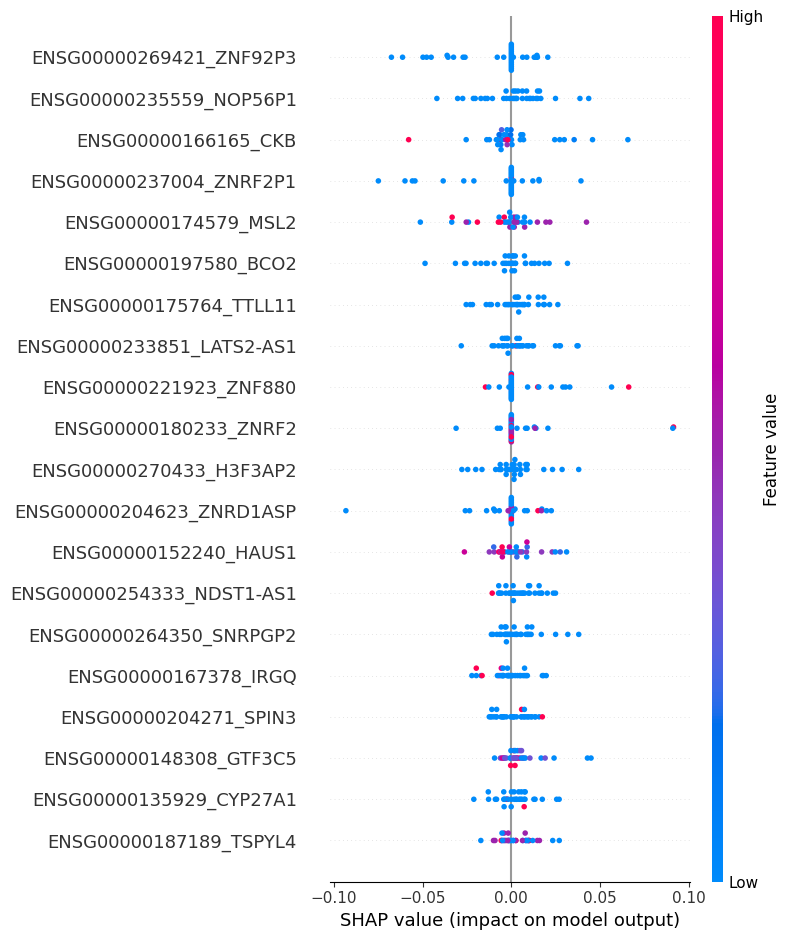

In [116]:
shap.initjs()
shap.summary_plot(attr_all_22085_genes, xtest_all_genes, feature_names=xtest_all_genes.columns)